In [1]:
import sys
from os.path import isfile
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import random
import logging
from add_spikes import add_spikes
from shift_spectrum import shift_spectrum
from get_redshift import get_redshift
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [2]:
# -- Logging info
logging.basicConfig(filename='modifications.txt', level=logging.INFO,
                    format='%(asctime)s - %(message)s', filemode='w')

In [3]:
def modify(spectrum, sn_name, delay_phase, sn_subtype, sn_maintype, spectral_phase):
    # --Error handling
    if not isinstance(spectrum, np.ndarray):
        raise TypeError(f"Error: Expected 'np.ndarray', got {type(spectrum).__name__}")
    if not isinstance(sn_name, str):
        raise TypeError(f"Error: Expected 'str', got {type(sn_name).__name__}")
    if not isinstance(delay_phase, float):
        raise TypeError(f"Error: Expected 'float', got {type(delay_phase).__name__}")

    # --Copy spectrum and log basic information
    modified_spectrum = spectrum.copy()
    logging.info(f'Object: {sn_name}, phase delay: {delay_phase}')

    # --Prepare modification details
    modification_details = {
        'Object': sn_name,
        'Phase Delay': delay_phase,
        'SN Subtype ID': sn_subtype,
        'SN Maintype ID': sn_maintype,
        'Spectral Phase': spectral_phase,
        'Modification Type': '',
        'Redshift Applied': False,
        'Spikes Added': False
    }

    # --Apply modifications
    modifications = random.randint(0, 3)
    if modifications == 0:
        logging.info('---Modifications: None')
        modification_details['Modification Type'] = 'None'
    else:
        try:
            redshift = get_redshift(sn_name)  # Intentar obtener el redshift
            print(redshift)
        except Exception as e:
            logging.warning(f"Warning: No se encontró redshift para {sn_name}. Detalle: {e}")
            redshift = 0.001  # Valor de redshift alternativo si no se encuentra el original
            logging.info(f'Usando redshift alternativo: {redshift}')
        
        if modifications == 1:
            logging.info('---Modifications: Shift spectra on x axis only')
            modified_spectrum = shift_spectrum(spectrum, redshift)
            modification_details['Modification Type'] = 'Shift Spectrum'
            modification_details['Redshift Applied'] = True

        elif modifications == 2:
            logging.info('---Modifications: Add spikes only')
            modified_spectrum = add_spikes(spectrum, redshift)
            modification_details['Modification Type'] = 'Add Spikes'
            modification_details['Spikes Added'] = True
        elif modifications == 3:
            logging.info('---Modifications: Add spikes first, then shift spectra on x axis')
            modified_spectrum = shift_spectrum(add_spikes(spectrum, redshift), redshift)
            modification_details['Modification Type'] = 'Add Spikes and Shift'
            modification_details['Spikes Added'] = True
            modification_details['Redshift Applied'] = True

    
    return modified_spectrum, modification_details


In [4]:
np.random.seed(3312)
url = "https://github.com/juanserrano90/codelatam/raw/main/Data/data/sn_data.parquet"
df_raw = pd.read_parquet(url)
wavelength = np.array([float(c) for c in df_raw.columns[5:]])
column_names = df_raw.columns.values.tolist()
column_names = np.array(column_names[5:]).astype(float)


In [5]:
data_aumentation_plan = pd.DataFrame(columns=['Type', 'N° of Copys'])

data_aumentation_plan['Type'] = ['IIP', 'IIn', 'Ic-pec', 'Ibn', 'Ib-pec','IIL']
data_aumentation_plan['N° of Copys'] = [41, 153 , 184, 186, 202, 204]

In [11]:
data_aumentation_plan = pd.DataFrame(columns=['Type', 'N° of Copys'])

data_aumentation_plan['Type'] = ['Ia-91T', 'Ia-91bg', 'Ia-pec', 'Iax', 'Ia-csm']
data_aumentation_plan['N° of Copys'] = [79, 213 , 336, 409, 447]

In [12]:
np.random.seed(1)
modified = []
modification_tables = pd.DataFrame()

for i in data_aumentation_plan['Type']:
    print(f"Procesando tipo: {i}")
    
    # Selecciona el subtipo a aumentar
    df_loc = df_raw[df_raw['SN Subtype'] == i]
    
    # Selecciona el número de copias necesarias
    n = data_aumentation_plan[data_aumentation_plan['Type'] == i]['N° of Copys'].values[0]

    # Contador para asegurar el número de copias por subtipo
    count = 0

    # Bucle para asegurar el número de copias deseado
    while count < n:
        # Selecciona una muestra
        df_loc_sampled = df_loc.sample(n=1, replace=True)
        
        # Aplica las modificaciones:
        for index, row in df_loc_sampled.iterrows():
            sn_name = index
            try:
                # Obtiene el valor de 'Spectral Phase'
                delay_phases = row['Spectral Phase']
                sn_subtype = row['SN Subtype ID']
                sn_maintype = row['SN Maintype ID']
                spectral_phase = row['Spectral Phase']
                
                # Intenta obtener la muestra correspondiente de df_raw
                sample = df_raw.loc[(df_raw.index == sn_name)].iloc[:, 5:].values[0]

                # Modifica el espectro y guarda la tabla de modificaciones
                mod_spectrum, mod_table = modify(sample, sn_name,delay_phases, sn_subtype, sn_maintype, spectral_phase)
                modified.append(mod_spectrum)
                
                # Convertir el diccionario a un DataFrame antes de concatenar
                mod_table_df = pd.DataFrame([mod_table])  # Convertir diccionario a DataFrame
                modification_tables = pd.concat([modification_tables, mod_table_df], ignore_index=True)

                # Incrementa el contador solo si se genera una modificación
                count += 1

            except IndexError as e:
                print(f"Error: No se encontró un valor para la supernova {sn_name}. Detalle: {e}")
            except KeyError as e:
                print(f"Error: Columna no encontrada en la fila de {sn_name}. Detalle: {e}")
            except Exception as e:
                print(f"Error inesperado para {sn_name}. Detalle: {e}")




    

Procesando tipo: Ia-91T
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1997br    0.006941
sn1997br    0.006941
Name: redshift, dtype: float64
Error inesperado para sn1997br. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.062573
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.05631713135508915
Wavelength shift: 352.0261051306252 Å
Pixel shift: 48
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 's

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005eq    0.028351
sn2005eq    0.028351
Name: redshift, dtype: float64
Error inesperado para sn2005eq. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0391
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.03729358822083622
Wavelength shift: 233.1140861019723 Å
Pixel shift: 31
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1998es    0.01057
sn1998es    0.01057
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn1998es    0.010267
sn1998es    0.010267
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn1998es    64.174054
sn1998es    64.174054
Name: redshift, dtype: float64 Å
Error inesperado para sn1998es. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1999aa    0.01444
sn1999aa    0.01444
Name: redshift, dtype: float64
Error inesperado para sn1999aa. Detalle: operands could not be

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1999aa    0.01444
sn1999aa    0.01444
Name: redshift, dtype: float64
Error inesperado para sn1999aa. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1997br    0.006941
sn1997br    0.006941
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn1997br    0.006695
sn1997br    0.006695
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn1997br    41.848021
sn1997br    41.848021
Name: redshift, dtype: float64 Å
Error inesperado para sn1997br. Deta

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1999by    0.002128
sn1999by    0.002128
Name: redshift, dtype: float64
Error inesperado para sn1999by. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005ke    0.00488
sn2005ke    0.00488
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005ke    0.004695
sn2005ke    0.004695
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005ke    29.346671
sn2005ke    29.346671
Name: redshift, dtype: float64 Å
Error inesperado para sn2005ke. Deta

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1991bg    0.003539
sn1991bg    0.003539
Name: redshift, dtype: float64
Error inesperado para sn1991bg. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009904809653492903
Wavelength shift: 6.191280486917487 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et'

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0162
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.01587325700599376
Wavelength shift: 99.22026752970338 Å
Pixel shift: 13
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009215327751887367
Wavelength shift: 5.760300388073513 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2007al    0.012122
sn2007al    0.012

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1991bg    0.003539
sn1991bg    0.003539
Name: redshift, dtype: float64
Error inesperado para sn1991bg. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.016251
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.01658188453129916
Wavelength shift: 103.64974363616119 Å
Pixel shift: 14
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', '

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2006gt    0.044771
sn2006gt    0.044771
Name: redshift, dtype: float64
Error inesperado para sn2006gt. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.017559
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0162
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.01696290251862489
Wavelength shift: 106.03140397353323 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.01647
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.016478751155328316
Wavelength shift: 103.00507939672977 Å
Pixel shift: 14
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.017559
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.018613706780717568
Wavelength shift: 116.35022136949435 Å
Pixel shift: 15
Columnas en el archivo CSV: ['SN_

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0162
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.01628359838264276
Wavelength shift: 101.78522197819791 Å
Pixel shift: 13
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001077965468289475
Wavelength shift: 6.738127034110075 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_n

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005bl    0.02406
sn2005bl    0.02406
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1999by    0.002128
sn1999by    0.002128
Name: redshift, dtype: float64
Error inesperado para sn1999by. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005bl    0.02406
sn2005bl    0.02406
Name: 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2006bz    0.027906
sn2006bz    0.027906
Name: redshift, dtype: float64
Error inesperado para sn2006bz. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2006bz    0.027906
sn2006bz    0.027906
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2006bz    0.028984
sn2006bz    0.028984
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2006bz    181.172625
sn2006bz    181.172625
Name: redshift, dtype: float64 Å
Error inesperado para sn2006bz. 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn1999by    0.002128
sn1999by    0.002128
Name: redshift, dtype: float64
Error inesperado para sn1999by. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Procesando tipo: Ia-pec
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.029591477087777627
Wavelength shift: 184.96986926751825 Å
Pixel shift: 25
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.029456213789806635
Wavelength shift: 184.1243678933161 Å
Pixel shift: 25
Columnas en el archivo CSV: ['SN_Name',

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010602776897612957
Wavelength shift: 6.627564588298896 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009887610396733038
Wavelength shift: 6.1805

Error inesperado para sn2000cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001006172392007756
Wavelength shift: 6.289364172602648 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.007291
sn2000cx    0.007291
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    45.573888
sn2000cx    45.573888
Name: redshift

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.07643534089208871
Wavelength shift: 477.7806450921456 Å
Pixel shift: 65
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06859360213185338
Wavelength shift: 428.7636464135003 Å
Pixel shift: 58
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000c

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.00849
sn2000cx    0.00849
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    53.066355
sn2000cx    53.066355
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk',

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.008026
sn2000cx    0.008026
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    50.167671
sn2000cx    50.167671
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009836993635078351
Wavelength shift: 6.148890172898439 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.07428200860067144
Wavelength shift: 464.3206345880572 Å
Pixel shift: 63
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Reds

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.07702219847740976
Wavelength shift: 481.44896386222564 Å
Pixel shift: 65
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009721149675803193
Wavelength shift: 6.076478640554188 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Red

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2000cx    49.563374
sn2000cx    49.563374
Name: redshift, dtype: float64 Å
Error inesperado para sn2000cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Error inesperado para sn2000cx. Detalle: operands could no

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Error inesperado para sn2000cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06985018268453361
Wavelength shift: 436.61825738354105 Å

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.07759506174852368
Wavelength shift: 485.02980722640734 Å
Pixel shift: 66
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.03006
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06592889350021147
Wavelength shift: 412.107133939697 Å
Pixel shift: 56
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.03006
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2000cx    0.007929
sn2000cx    0.007929
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2000cx    0.008527
sn

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.028
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.03004073106551075
Wavelength shift: 187.7780578984106 Å
Pixel shift: 25
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001030893870245487
Wavelength shift: 6.443892741222888 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.0074
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.007535346115693335
Wavelength shift: 47.10180508295727 Å
Pixel shift: 6
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0795365100823223
Wavelength shift: 497.1653773240791 Å
Pixel shift: 67
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.073092
Central wavelength: 6250.78189

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002c

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010790917121936696
Wavelength shift: 6.745166939117326 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.013353
sn2005hk    0.013353
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    83.469103
sn2005hk    83.469103
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Column

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.014047
sn2005hk    0.014047
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    87.803723
sn2005hk    87.803723
Name: redshift, dtype: float64 Å

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010933696347317369
Wavelength shift: 6.8344151188362385 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.012672
sn2005hk    0.012672
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    79.208113
sn2005hk    79.208113
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Colum

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.013722
sn2005hk    0.013722
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    85.776086
sn2005hk    85.776086
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Error inesperado para sn2002cx. Detalle: operands could not be

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009270708781724147
Wavelength shift: 5.794917861944192 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010456456252667533
Wavelength shift: 6.5361027444497 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'r

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2002cx    0.022848
sn2002cx    0.022848
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2002cx    142.819692
sn2002cx    142.819692
Name: redshift, dtype: float64 Å
Error inesperado para sn2002cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009107172081788572
Wavelength shift: 5.692694637609039 Å
Pixel shift: 0
Colu

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010870091453826418
Wavelength shift: 6.794657087160777 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.014183
sn2005hk    0.014183
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    88.657492
sn2005hk    88.657492
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Column

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001094270631034013
Wavelength shift: 6.840047050211215 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009329002605877326
Wavelength shift: 5.8313560

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.013388
sn2005hk    0.013388
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    83.682357
sn2005hk    83.682357
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Error inesperado para sn2002cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002c

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001003796732865809
Wavelength shift: 6.274514445446189 Å
Pixel shift: 0
C

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009563537830545373
Wavelength shift: 5.977958913654875 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009480486380631572
Wavelength shift: 5.9260452636959196 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift va

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2002cx    0.023803
sn2002cx    0.023803
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2002cx    148.788058
sn2002cx    148.788058
Name: redshift, dtype: float64 Å
Error inesperado para sn2002cx. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variati

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Error inesperado para sn2002cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variati

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010746825455577554
Wavelength shift: 6.717606200131417 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2002cx    0.025742
sn2002cx    0.025742
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2002cx    160.907838
sn2002cx    160.907838
Name: redshift, dtype: float64 Å
Error inesperado para sn2002cx. Detalle: cannot convert the series to <class 'int'>
Colu

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010909807913304392
Wavelength shift: 6.819482979750113 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.014186
sn2005hk    0.014186
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    88.672308
sn2005hk    88.672308
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Column

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.011968
sn2005hk    0.011968
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    74.807462
sn2005hk    74.807462
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detall

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009052803911048699
Wavelength shift: 5.658710279869012 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2002cx    0.02396
sn2002cx    0.02396
Name: redshift, dtype: float64
Error inesperado para sn2002cx. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002c

Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Error inesperado para sn2005hk. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005hk    0.01306
sn2005hk    0.01306
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005hk    0.012904
sn2005hk    0.012904
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005hk    80.657982
sn2005hk    80.657982
Name: redshift, dtype: float64 Å
Error inesperado para sn2005hk. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.056168
sn2005gj    0.056168
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    351.092617
sn2005gj    351.092617
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be b

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06643727229933877
Wavelength shift: 415.28489893378696 Å
Pixel shift: 56
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.060857
sn2005gj    0.060857
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    380.400848
sn2005gj    380.400848
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06165023106770065
Wavelength shift: 385.3621482658235 Å
Pixel shift: 52
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift varia

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.066319
sn2005gj    0.066319
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    414.545725
sn2005gj    414.545725
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_N

SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.06752
sn2005gj    0.06752
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    422.051766
sn2005gj    422.051766
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn200

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06635864486564125
Wavelength shift: 414.7934159946714 Å
Pixel shift: 56
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06594987075277975
Wavelength shift: 412.23825817028666 Å
Pixel shift: 56
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006e

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.059461
sn2005gj    0.059461
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    371.677089
sn2005gj    371.677089
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.060787
sn2005gj    0.060787
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    379.967306
sn2005gj    379.967306
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.061723
sn2005gj    0.061723
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    385.819478
sn2005gj    385.819478
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.064213
sn2005gj    0.064213
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    401.378972
sn2005gj    401.378972
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06359387961520598
Wavelength shift: 397.5114714195013 Å
Pixel shift: 54
C

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.057298
sn2005gj    0.057298
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    358.154603
sn2005gj    358.154603
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009362378375838831
Wavelength shift: 5.852218525878279 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06978285908272047
Wavelength shift: 436.19743223212816 Å
Pixel shift: 59
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616


Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.058689
sn2005gj    0.058689
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    366.854513
sn2005gj    366.854513
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk',

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06366784095644248
Wavelength shift: 397.9737876323347 Å
Pixel shift: 54
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06438443368424315
Wavelength shift: 402.4530524823509 Å
Pixel shift: 54
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024

0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.07113429376839567
Wavelength shift: 444.644955699491 Å
Pixel shift: 60
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name',

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.063961
sn2005gj    0.063961
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    399.805092
sn2005gj    399.805092
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle: cannot convert the series to <class 'int'>
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn19

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009522049210966382
Wavelength shift: 5.952025282437847 Å
Pixel shift: 0
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.064493
sn2005gj    0.064493
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    403.129932
sn2005gj    403.129932
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.064225
sn2005gj    0.064225
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    401.458828
sn2005gj    401.458828
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
0.066
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.06572224378765071
Wavelength shift: 410.8154116575294 Å
Pixel shift: 56
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et

Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Error inesperado para sn2005gj. Detalle: operands could not be broadcast together with shapes (1024,) (2,) 
Columnas en el archivo CSV: ['SN_Name', 'old_name', 'redshift', 'year']
Available SN names or old names: ['sn2008ar', 'sn1999ac', 'sn1998dk', 'sn2005gj', 'sn2004eo', 'sn2002cr', 'sn2006ej', 'sn2003ai', 'sn2001br', 'sn2006et']
SN_Name
sn2005gj    0.0616
sn2005gj    0.0616
Name: redshift, dtype: float64
Central wavelength: 6250.781896383187 Å
Redshift variation: SN_Name
sn2005gj    0.055781
sn2005gj    0.055781
Name: redshift, dtype: float64
Wavelength shift: SN_Name
sn2005gj    348.677759
sn2005gj    348.677759
Name: redshift, dtype: float64 Å
Error inesperado para sn2005gj. Detalle:

In [13]:
print(i)

Ia-csm


In [14]:
modification_tables['Modification Type'].value_counts()


None                    602
Add Spikes              363
Add Spikes and Shift    269
Shift Spectrum          250
Name: Modification Type, dtype: int64

In [15]:
modification_tables.to_csv('Modification_Ia_pec.csv', index=False)

In [16]:
if isinstance(modified, list):
    # Extraer el primer array de cada elemento
    extracted_arrays = []
    for item in modified:
        if isinstance(item, tuple):
            extracted_arrays.append(item[0])  # Toma el primer array de la tupla
        elif isinstance(item, np.ndarray):
            extracted_arrays.append(item)  # Toma directamente el array si es un array
        else:
            print(f"Elemento ignorado: {item}, tipo: {type(item)}")
    
    # Convertir los arrays extraídos a un DataFrame
    modified_df = pd.DataFrame(extracted_arrays)
    
    # Exportar a CSV
    modified_df.to_csv('Ia-peculiars-copy.csv', index=False)
    print("Archivo CSV generado exitosamente.")
else:
    print("Error: 'modified' no es una lista.")

Archivo CSV generado exitosamente.


# Leer los df y concadenarlos a la tabla principal

In [17]:
Iapec = pd.read_csv('Ia-peculiars-copy.csv')
II = pd.read_csv('II-copy.csv')

In [18]:
nuevos_nombres = [f'{i}' for i in wavelength]
Iapec.columns = nuevos_nombres
II.columns = nuevos_nombres

In [19]:
#Marcar las copias

Iapec['COPY'] =True
II['COPY'] = True

In [20]:
#Leer las tablas csv :

modification_iapec = pd.read_csv('Modification_Ia_pec.csv')
modification_ii = pd.read_csv('Modification_II.csv')

In [21]:
modification_iapec

,Object,Phase Delay,SN Subtype ID,SN Maintype ID,Spectral Phase,Modification Type,Redshift Applied,Spikes Added
0,sn2006oa,-2.000,1,0,-2.000,Add Spikes and Shift,True,True
1,sn1999cw,24.500,1,0,24.500,Add Spikes and Shift,True,True
2,sn08ds,21.426,1,0,21.426,Add Spikes,False,True
3,sn2001ah,44.300,1,0,44.300,None,False,False
4,sn2007S,33.700,1,0,33.700,Add Spikes,False,True
...,...,...,...,...,...,...,...,...
1479,sn2005gj,51.800,3,0,51.800,Add Spikes,False,True
1480,sn2005gj,51.800,3,0,51.800,None,False,False
1481,sn2002ic,9.400,3,0,9.400,Shift Spectrum,True,False
1482,sn2002ic,9.400,3,0,9.400,Add Spikes and Shift,True,True


In [22]:
#Concadenar hacia al lado

snIapec = pd.concat([Iapec, modification_iapec], axis=1)
snii = pd.concat([II, modification_ii], axis=1)

In [23]:
df_raw = df_raw.reset_index()
df_raw = df_raw.rename(columns={'SN Name': 'Object'})
df_raw

,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,sn2008ar,Ia-norm,0,Ia,0,-8.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sn2008ar,Ia-norm,0,Ia,0,-7.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sn2008ar,Ia-norm,0,Ia,0,-6.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sn2008ar,Ia-norm,0,Ia,0,-4.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sn2008ar,Ia-norm,0,Ia,0,-3.70,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,sn2007uy,Ib-pec,9,Ib,1,12.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,sn2007uy,Ib-pec,9,Ib,1,45.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,sn2007uy,Ib-pec,9,Ib,1,54.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4999,sn2007uy,Ib-pec,9,Ib,1,75.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Hacer el df por clases

- Revisar que la clase 0 tenga 2387 elementos
- Unir el df 1 con el df1 de las copias
- Elegir los datos del df2 para generar imagenes 

In [27]:
#DF0
df_raw_0 = df_raw[df_raw['SN Subtype ID']== 0]
df_raw_0 

,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,sn2008ar,Ia-norm,0,Ia,0,-8.500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sn2008ar,Ia-norm,0,Ia,0,-7.500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sn2008ar,Ia-norm,0,Ia,0,-6.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sn2008ar,Ia-norm,0,Ia,0,-4.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sn2008ar,Ia-norm,0,Ia,0,-3.700,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,sn1990O,Ia-norm,0,Ia,0,-5.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3993,sn1990O,Ia-norm,0,Ia,0,-0.900,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,sn1990O,Ia-norm,0,Ia,0,18.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3995,sn1990O,Ia-norm,0,Ia,0,19.400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#DF1
df_raw_1 = df_raw[(df_raw['SN Subtype ID']== 1) | (df_raw['SN Subtype ID']== 2) | (df_raw['SN Subtype ID']== 3) |
                  (df_raw['SN Subtype ID']== 4) | (df_raw['SN Subtype ID']== 5)]
df_raw_1 =  pd.concat([df_raw_1, snIapec], axis=0)
df_raw_1

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
18,sn1999ac,Ia-91T,1,Ia,0,-13.9,0.0,0.0,0.0,0.0,...,0.001,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
19,sn1999ac,Ia-91T,1,Ia,0,-12.9,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20,sn1999ac,Ia-91T,1,Ia,0,-9.9,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
21,sn1999ac,Ia-91T,1,Ia,0,-3.9,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
22,sn1999ac,Ia-91T,1,Ia,0,-2.9,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,sn2005gj,NaN,3,NaN,0,51.8,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,51.8,Add Spikes,False,True
1480,sn2005gj,NaN,3,NaN,0,51.8,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,51.8,None,False,False
1481,sn2002ic,NaN,3,NaN,0,9.4,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,9.4,Shift Spectrum,True,False
1482,sn2002ic,NaN,3,NaN,0,9.4,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,9.4,Add Spikes and Shift,True,True


In [29]:
#Muestrame todo en los que el spectral phase sea nan

df_raw_1["Spectral Phase"] = df_raw_1["Spectral Phase"].fillna(df_raw_1["Phase Delay"])
df_raw_1

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
18,sn1999ac,Ia-91T,1,Ia,0,-13.9,0.0,0.0,0.0,0.0,...,0.001,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
19,sn1999ac,Ia-91T,1,Ia,0,-12.9,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20,sn1999ac,Ia-91T,1,Ia,0,-9.9,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
21,sn1999ac,Ia-91T,1,Ia,0,-3.9,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
22,sn1999ac,Ia-91T,1,Ia,0,-2.9,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,sn2005gj,NaN,3,NaN,0,51.8,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,51.8,Add Spikes,False,True
1480,sn2005gj,NaN,3,NaN,0,51.8,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,51.8,None,False,False
1481,sn2002ic,NaN,3,NaN,0,9.4,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,9.4,Shift Spectrum,True,False
1482,sn2002ic,NaN,3,NaN,0,9.4,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,True,9.4,Add Spikes and Shift,True,True


In [30]:
#DF2

#Elegir 217 de cada clase que tiene exceso
df_raw_8 = df_raw[df_raw['SN Subtype ID']==8].sample(n=217)
df_raw_11 = df_raw[df_raw['SN Subtype ID']==11].sample(n=217)
df_raw_6 = df_raw[df_raw['SN Subtype ID']==6].sample(n=217)
df_raw_10 = df_raw[df_raw['SN Subtype ID']==10].sample(n=217)
df_raw_16 = df_raw[df_raw['SN Subtype ID']==16].sample(n=217)

#Agregar las clases que faltan sin seleccionar
df_raw_13 = df_raw[df_raw['SN Subtype ID']==13]
df_raw_15 = df_raw[df_raw['SN Subtype ID']==15]
df_raw_12 = df_raw[df_raw['SN Subtype ID']==12]
df_raw_7 = df_raw[df_raw['SN Subtype ID']==7]
df_raw_9 = df_raw[df_raw['SN Subtype ID']==9]
df_raw_14 = df_raw[df_raw['SN Subtype ID']==14]


#Concadenar los df incluyendo el de las copias
II_completo = pd.concat([df_raw_8, df_raw_11, df_raw_6, df_raw_10, df_raw_16, 
                        df_raw_13, df_raw_15, df_raw_12, df_raw_7, df_raw_9, df_raw_14, 
                        snii], axis=0)

In [31]:
II_completo

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
4001,sn2013df,IIb,8,Ib,1,-3.77,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4818,sn2008ax,IIb,8,Ib,1,-9.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4159,sn2012P,IIb,8,Ib,1,-7.96,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4395,sn1996cb,IIb,8,Ib,1,147.90,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4391,sn1996cb,IIb,8,Ib,1,100.30,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,sn1980K,NaN,14,NaN,3,11.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,11.0,Add Spikes,False,True
966,sn1979C,NaN,14,NaN,3,71.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,71.6,Add Spikes and Shift,True,True
967,sn1980K,NaN,14,NaN,3,66.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,66.0,Add Spikes and Shift,True,True
968,sn1980K,NaN,14,NaN,3,12.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,12.0,Shift Spectrum,True,False


In [32]:
#Concaderas todos

main = pd.concat([df_raw_0, df_raw_1, II_completo], axis=0)
main = main.reset_index(drop=True)

In [33]:
main_wavelenght = main.iloc[:, 6:1030]
main_wavelenght 

,2501.69,2505.08,2508.48,2511.87,2515.28,2518.69,2522.1,2525.51,2528.94,2532.36,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Asegurarse de que todas las columnas tienen nombres de tipo string
#scalings ={}

main_wavelenght.columns = main_wavelenght.columns.astype(str)

# Ahora puedes aplicar el escalado
#scalings['minmax'] = minmax_scaler.fit_transform(main_wavelenght )

# Convertir a DataFrame para mantener las columnas originales
#main_wavelength_scaled = pd.DataFrame(scalings['minmax'], columns=main_wavelenght .columns)

#main_wavelength_scaled

In [35]:
#Rellenar el df con los subtipos:

In [36]:
main

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
0,sn2008ar,Ia-norm,0,Ia,0,-8.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,sn2008ar,Ia-norm,0,Ia,0,-7.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,sn2008ar,Ia-norm,0,Ia,0,-6.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,sn2008ar,Ia-norm,0,Ia,0,-4.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,sn2008ar,Ia-norm,0,Ia,0,-3.7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,sn1980K,NaN,14,NaN,3,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,11.0,Add Spikes,False,True
7155,sn1979C,NaN,14,NaN,3,71.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,71.6,Add Spikes and Shift,True,True
7156,sn1980K,NaN,14,NaN,3,66.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,66.0,Add Spikes and Shift,True,True
7157,sn1980K,NaN,14,NaN,3,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,12.0,Shift Spectrum,True,False


In [37]:
# Hacerles el nombre
main['Name'] = main['Object'] + '_' + main['SN Subtype ID'].astype(str) + '_' + \
               main['SN Maintype ID'].astype(str) + '_' + main['Spectral Phase'].astype(str) + '_' + \
               main.index.astype(str)

# Agregar "COPY" si la columna 'copy' es True
main['Name'] = main.apply(lambda row: row['Name'] + '_COPY' if row['COPY'] ==True else row['Name'], axis=1)

# Agregar la extensión ".png" al final de la cadena
main['Name'] = main['Name'] + '.png'

# Ver el resultado
print(main[['Name']])

                                 Name
0             sn2008ar_0_0_-8.5_0.png
1             sn2008ar_0_0_-7.5_1.png
2             sn2008ar_0_0_-6.6_2.png
3             sn2008ar_0_0_-4.6_3.png
4             sn2008ar_0_0_-3.7_4.png
...                               ...
7154  sn1980K_14_3_11.0_7154_COPY.png
7155  sn1979C_14_3_71.6_7155_COPY.png
7156  sn1980K_14_3_66.0_7156_COPY.png
7157  sn1980K_14_3_12.0_7157_COPY.png
7158  sn1979C_14_3_42.8_7158_COPY.png

[7159 rows x 1 columns]


In [38]:
for i in main['Name']:
    print(i)

sn2008ar_0_0_-8.5_0.png
sn2008ar_0_0_-7.5_1.png
sn2008ar_0_0_-6.6_2.png
sn2008ar_0_0_-4.6_3.png
sn2008ar_0_0_-3.7_4.png
sn2008ar_0_0_-2.7_5.png
sn2008ar_0_0_-1.7_6.png
sn2008ar_0_0_-0.7_7.png
sn2008ar_0_0_1.2_8.png
sn2008ar_0_0_3.1_9.png
sn2008ar_0_0_4.1_10.png
sn2008ar_0_0_5.0_11.png
sn2008ar_0_0_7.2_12.png
sn2008ar_0_0_22.6_13.png
sn2008ar_0_0_25.7_14.png
sn2008ar_0_0_28.4_15.png
sn2008ar_0_0_55.6_16.png
sn2008ar_0_0_105.1_17.png
sn1998dk_0_0_10.2_18.png
sn1998dk_0_0_11.1_19.png
sn1998dk_0_0_13.1_20.png
sn1998dk_0_0_16.1_21.png
sn1998dk_0_0_18.1_22.png
sn1998dk_0_0_21.0_23.png
sn1998dk_0_0_23.0_24.png
sn1998dk_0_0_29.9_25.png
sn1998dk_0_0_44.7_26.png
sn04eo_0_0_-5.57_27.png
sn04eo_0_0_13.193_28.png
sn04eo_0_0_44.403_29.png
sn2002cr_0_0_-11.2_30.png
sn2002cr_0_0_-8.2_31.png
sn2002cr_0_0_-6.3_32.png
sn2002cr_0_0_-2.4_33.png
sn2002cr_0_0_0.7_34.png
sn2002cr_0_0_4.6_35.png
sn2002cr_0_0_19.4_36.png
sn06ej_0_0_-3.695_37.png
sn06ej_0_0_5.095_38.png
sn06ej_0_0_21.651_39.png
sn06ej_0_0_27.541

In [39]:
main_wavelenght_t = main_wavelenght.T


In [40]:
main_wavelenght_t.columns = main['Name']
main_wavelenght_t

Name,sn2008ar_0_0_-8.5_0.png,sn2008ar_0_0_-7.5_1.png,sn2008ar_0_0_-6.6_2.png,sn2008ar_0_0_-4.6_3.png,sn2008ar_0_0_-3.7_4.png,sn2008ar_0_0_-2.7_5.png,sn2008ar_0_0_-1.7_6.png,sn2008ar_0_0_-0.7_7.png,sn2008ar_0_0_1.2_8.png,sn2008ar_0_0_3.1_9.png,...,sn1980K_14_3_41.0_7149_COPY.png,sn1980K_14_3_11.0_7150_COPY.png,sn1980K_14_3_44.0_7151_COPY.png,sn1980K_14_3_41.0_7152_COPY.png,sn1979C_14_3_9.9_7153_COPY.png,sn1980K_14_3_11.0_7154_COPY.png,sn1979C_14_3_71.6_7155_COPY.png,sn1980K_14_3_66.0_7156_COPY.png,sn1980K_14_3_12.0_7157_COPY.png,sn1979C_14_3_42.8_7158_COPY.png
2501.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2505.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2508.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2511.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2515.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9939.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9952.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9966.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9979.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
cd ..


/Users/valentina/codelatam/DataPreparation


In [42]:
cd ..

/Users/valentina/codelatam


In [43]:
ls

Data/            DataPreparation/ README.md        Training/


In [44]:
cd Data

/Users/valentina/codelatam/Data


In [45]:
mkdir augmented_images_v2

In [46]:
cd augmented_images_v2/

/Users/valentina/codelatam/Data/augmented_images_v2


In [49]:
mkdir 2

In [50]:
ls


0/ 1/ 2/


In [51]:
for i in range(0, len(main_wavelenght_t.columns)):
    # Definir el DPI y el tamaño de la figura
    my_dpi = 100
    print(i)
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(2.65, 2.65), dpi=my_dpi)
    
    # Graficar la columna de datos
    ax.plot(wavelength, main_wavelenght_t.iloc[:, i].values, lw=1, ls='-', color='k', alpha=1)
    
    # Configurar los ejes y la apariencia
    ax.axis('off')
    ax.set_xlim(2500, 10000)
    # ax.set_ylim(0, 1)  # Descomentarlo si es necesario
    ax.set_box_aspect(1)
    
    # Extraer el primer número después del primer guion bajo en el nombre de la columna
    first_num = int(main_wavelenght_t.columns[i].split('_')[1])
    
    # Determinar la carpeta de destino según el valor de first_num
    if first_num == 0:
        target_folder = '0'
    elif 1 <= first_num <= 5:
        target_folder = '1'
    else:
        target_folder = '2'
    
    # Guardar la imagen con el nombre de la columna en la carpeta correspondiente
    file_path = os.path.join(target_folder, f'{main_wavelenght_t.columns[i]}')
    plt.savefig(file_path, bbox_inches='tight', dpi=my_dpi)

    # Cerrar la figura después de guardar
    plt.close()
    
    print(f'Imagen guardada en {file_path}')

0
Imagen guardada en 0/sn2008ar_0_0_-8.5_0.png
1
Imagen guardada en 0/sn2008ar_0_0_-7.5_1.png
2
Imagen guardada en 0/sn2008ar_0_0_-6.6_2.png
3
Imagen guardada en 0/sn2008ar_0_0_-4.6_3.png
4
Imagen guardada en 0/sn2008ar_0_0_-3.7_4.png
5
Imagen guardada en 0/sn2008ar_0_0_-2.7_5.png
6
Imagen guardada en 0/sn2008ar_0_0_-1.7_6.png
7
Imagen guardada en 0/sn2008ar_0_0_-0.7_7.png
8
Imagen guardada en 0/sn2008ar_0_0_1.2_8.png
9
Imagen guardada en 0/sn2008ar_0_0_3.1_9.png
10
Imagen guardada en 0/sn2008ar_0_0_4.1_10.png
11
Imagen guardada en 0/sn2008ar_0_0_5.0_11.png
12
Imagen guardada en 0/sn2008ar_0_0_7.2_12.png
13
Imagen guardada en 0/sn2008ar_0_0_22.6_13.png
14
Imagen guardada en 0/sn2008ar_0_0_25.7_14.png
15
Imagen guardada en 0/sn2008ar_0_0_28.4_15.png
16
Imagen guardada en 0/sn2008ar_0_0_55.6_16.png
17
Imagen guardada en 0/sn2008ar_0_0_105.1_17.png
18
Imagen guardada en 0/sn1998dk_0_0_10.2_18.png
19
Imagen guardada en 0/sn1998dk_0_0_11.1_19.png
20
Imagen guardada en 0/sn1998dk_0_0_13.1_20

Imagen guardada en 0/sn2001ay_0_0_1.3_170.png
171
Imagen guardada en 0/sn2001ay_0_0_3.3_171.png
172
Imagen guardada en 0/sn2001ay_0_0_3.3_172.png
173
Imagen guardada en 0/sn2001ay_0_0_4.2_173.png
174
Imagen guardada en 0/sn2001ay_0_0_5.8_174.png
175
Imagen guardada en 0/sn2001ay_0_0_7.2_175.png
176
Imagen guardada en 0/sn2001ay_0_0_7.8_176.png
177
Imagen guardada en 0/sn2001ay_0_0_9.0_177.png
178
Imagen guardada en 0/sn2001ay_0_0_16.5_178.png
179
Imagen guardada en 0/sn2001ay_0_0_22.6_179.png
180
Imagen guardada en 0/sn2001ay_0_0_23.3_180.png
181
Imagen guardada en 0/sn2001ay_0_0_29.4_181.png
182
Imagen guardada en 0/sn2001ay_0_0_29.5_182.png
183
Imagen guardada en 0/sn2001ay_0_0_30.4_183.png
184
Imagen guardada en 0/sn2001ay_0_0_31.4_184.png
185
Imagen guardada en 0/sn2001ay_0_0_31.4_185.png
186
Imagen guardada en 0/sn2001ay_0_0_36.3_186.png
187
Imagen guardada en 0/sn2001ay_0_0_54.6_187.png
188
Imagen guardada en 0/sn2001ay_0_0_54.7_188.png
189
Imagen guardada en 0/sn06cq_0_0_1.914_1

Imagen guardada en 0/sn2002bo_0_0_79.1_336.png
337
Imagen guardada en 0/sn2002bo_0_0_82.9_337.png
338
Imagen guardada en 0/sn2002bo_0_0_310.4_338.png
339
Imagen guardada en 0/sn1991M_0_0_2.7_339.png
340
Imagen guardada en 0/sn1991M_0_0_24.8_340.png
341
Imagen guardada en 0/sn1991M_0_0_25.8_341.png
342
Imagen guardada en 0/sn1991M_0_0_27.5_342.png
343
Imagen guardada en 0/sn1991M_0_0_80.0_343.png
344
Imagen guardada en 0/sn1991M_0_0_111.8_344.png
345
Imagen guardada en 0/sn07af_0_0_-1.209_345.png
346
Imagen guardada en 0/sn07af_0_0_3.852_346.png
347
Imagen guardada en 0/sn07af_0_0_26.491_347.png
348
Imagen guardada en 0/sn07af_0_0_91.057_348.png
349
Imagen guardada en 0/sn07af_0_0_113.823_349.png
350
Imagen guardada en 0/sn07af_0_0_121.788_350.png
351
Imagen guardada en 0/sn2007af_0_0_-5.6_351.png
352
Imagen guardada en 0/sn2007af_0_0_-4.6_352.png
353
Imagen guardada en 0/sn2007af_0_0_-3.6_353.png
354
Imagen guardada en 0/sn2007af_0_0_-2.6_354.png
355
Imagen guardada en 0/sn2007af_0_0_-

Imagen guardada en 0/sn2003cg_0_0_0.8_499.png
500
Imagen guardada en 0/sn2003cg_0_0_1.0_500.png
501
Imagen guardada en 0/sn2003cg_0_0_1.8_501.png
502
Imagen guardada en 0/sn2003cg_0_0_1.9_502.png
503
Imagen guardada en 0/sn2003cg_0_0_2.8_503.png
504
Imagen guardada en 0/sn2003cg_0_0_4.0_504.png
505
Imagen guardada en 0/sn2003cg_0_0_6.8_505.png
506
Imagen guardada en 0/sn2003cg_0_0_7.0_506.png
507
Imagen guardada en 0/sn2003cg_0_0_7.7_507.png
508
Imagen guardada en 0/sn2003cg_0_0_8.8_508.png
509
Imagen guardada en 0/sn2003cg_0_0_9.2_509.png
510
Imagen guardada en 0/sn2003cg_0_0_9.8_510.png
511
Imagen guardada en 0/sn2003cg_0_0_10.8_511.png
512
Imagen guardada en 0/sn2003cg_0_0_11.0_512.png
513
Imagen guardada en 0/sn2003cg_0_0_11.9_513.png
514
Imagen guardada en 0/sn2003cg_0_0_15.9_514.png
515
Imagen guardada en 0/sn2003cg_0_0_18.9_515.png
516
Imagen guardada en 0/sn2003cg_0_0_22.9_516.png
517
Imagen guardada en 0/sn2003cg_0_0_22.9_517.png
518
Imagen guardada en 0/sn2003cg_0_0_25.9_518.

Imagen guardada en 0/sn2004L_0_0_31.4_668.png
669
Imagen guardada en 0/sn1999ek_0_0_-0.6_669.png
670
Imagen guardada en 0/sn1999ek_0_0_3.3_670.png
671
Imagen guardada en 0/sn1999ek_0_0_9.2_671.png
672
Imagen guardada en 0/sn1999ek_0_0_12.2_672.png
673
Imagen guardada en 0/sn05cf_0_0_-10.944_673.png
674
Imagen guardada en 0/sn05cf_0_0_-2.109_674.png
675
Imagen guardada en 0/sn05cf_0_0_-1.187_675.png
676
Imagen guardada en 0/sn05cf_0_0_18.693_676.png
677
Imagen guardada en 0/sn05cf_0_0_27.642_677.png
678
Imagen guardada en 0/sn04ef_0_0_-5.519_678.png
679
Imagen guardada en 0/sn04ef_0_0_8.053_679.png
680
Imagen guardada en 0/sn04ef_0_0_31.228_680.png
681
Imagen guardada en 0/sn04ef_0_0_84.596_681.png
682
Imagen guardada en 0/sn2003kf_0_0_-9.4_682.png
683
Imagen guardada en 0/sn2003kf_0_0_-9.3_683.png
684
Imagen guardada en 0/sn2003kf_0_0_-8.4_684.png
685
Imagen guardada en 0/sn2003kf_0_0_-7.4_685.png
686
Imagen guardada en 0/sn2003kf_0_0_-5.4_686.png
687
Imagen guardada en 0/sn2003kf_0_0_

Imagen guardada en 0/sn2004ef_0_0_0.6_833.png
834
Imagen guardada en 0/sn2004ef_0_0_1.5_834.png
835
Imagen guardada en 0/sn2004ef_0_0_2.5_835.png
836
Imagen guardada en 0/sn2004ef_0_0_6.3_836.png
837
Imagen guardada en 0/sn2004ef_0_0_19.9_837.png
838
Imagen guardada en 0/sn2004ef_0_0_25.7_838.png
839
Imagen guardada en 0/sn2004ef_0_0_33.4_839.png
840
Imagen guardada en 0/sn99gd_0_0_0.167_840.png
841
Imagen guardada en 0/sn2004at_0_0_-8.6_841.png
842
Imagen guardada en 0/sn2004at_0_0_-7.4_842.png
843
Imagen guardada en 0/sn2004at_0_0_-6.6_843.png
844
Imagen guardada en 0/sn2004at_0_0_-4.7_844.png
845
Imagen guardada en 0/sn2004at_0_0_-3.6_845.png
846
Imagen guardada en 0/sn2004at_0_0_-0.7_846.png
847
Imagen guardada en 0/sn2004at_0_0_0.2_847.png
848
Imagen guardada en 0/sn2004at_0_0_1.2_848.png
849
Imagen guardada en 0/sn2004at_0_0_2.2_849.png
850
Imagen guardada en 0/sn2004at_0_0_17.8_850.png
851
Imagen guardada en 0/sn2004at_0_0_29.6_851.png
852
Imagen guardada en 0/sn1998co_0_0_0.0_8

Imagen guardada en 0/sn1995al_0_0_15.4_1004.png
1005
Imagen guardada en 0/sn1995al_0_0_16.4_1005.png
1006
Imagen guardada en 0/sn1995al_0_0_16.4_1006.png
1007
Imagen guardada en 0/sn1995al_0_0_18.3_1007.png
1008
Imagen guardada en 0/sn1995al_0_0_19.4_1008.png
1009
Imagen guardada en 0/sn1995al_0_0_25.2_1009.png
1010
Imagen guardada en 0/sn1995al_0_0_44.2_1010.png
1011
Imagen guardada en 0/sn1995al_0_0_67.9_1011.png
1012
Imagen guardada en 0/sn1995al_0_0_93.8_1012.png
1013
Imagen guardada en 0/sn2000E_0_0_-6.4_1013.png
1014
Imagen guardada en 0/sn2000E_0_0_-3.4_1014.png
1015
Imagen guardada en 0/sn2000E_0_0_-2.3_1015.png
1016
Imagen guardada en 0/sn2000E_0_0_7.5_1016.png
1017
Imagen guardada en 0/sn2000E_0_0_117.6_1017.png
1018
Imagen guardada en 0/sn2000E_0_0_119.7_1018.png
1019
Imagen guardada en 0/sn2000E_0_0_120.3_1019.png
1020
Imagen guardada en 0/sn02er_0_0_-11.3_1020.png
1021
Imagen guardada en 0/sn02er_0_0_-9.4_1021.png
1022
Imagen guardada en 0/sn02er_0_0_-8.4_1022.png
1023
Ima

Imagen guardada en 0/sn94ae_0_0_10.4_1169.png
1170
Imagen guardada en 0/sn94ae_0_0_11.3_1170.png
1171
Imagen guardada en 0/sn94ae_0_0_30.2_1171.png
1172
Imagen guardada en 0/sn94ae_0_0_36.2_1172.png
1173
Imagen guardada en 0/sn94ae_0_0_40.1_1173.png
1174
Imagen guardada en 0/sn94ae_0_0_64.0_1174.png
1175
Imagen guardada en 0/sn94ae_0_0_70.0_1175.png
1176
Imagen guardada en 0/sn94ae_0_0_87.8_1176.png
1177
Imagen guardada en 0/sn94ae_0_0_123.6_1177.png
1178
Imagen guardada en 0/sn94ae_0_0_153.4_1178.png
1179
Imagen guardada en 0/sn94ae_0_0_367.7_1179.png
1180
Imagen guardada en 0/sn2006cq_0_0_-3.3_1180.png
1181
Imagen guardada en 0/sn05de_0_0_-0.748_1181.png
1182
Imagen guardada en 0/sn05de_0_0_10.097_1182.png
1183
Imagen guardada en 0/sn05de_0_0_25.745_1183.png
1184
Imagen guardada en 0/sn05de_0_0_40.49_1184.png
1185
Imagen guardada en 0/sn2007au_0_0_-5.6_1185.png
1186
Imagen guardada en 0/sn2007au_0_0_-4.7_1186.png
1187
Imagen guardada en 0/sn2007au_0_0_-3.8_1187.png
1188
Imagen guarda

Imagen guardada en 0/sn2002hd_0_0_12.0_1330.png
1331
Imagen guardada en 0/sn2002hd_0_0_15.8_1331.png
1332
Imagen guardada en 0/sn2006S_0_0_-5.5_1332.png
1333
Imagen guardada en 0/sn2006S_0_0_-4.6_1333.png
1334
Imagen guardada en 0/sn2006S_0_0_-2.6_1334.png
1335
Imagen guardada en 0/sn2006S_0_0_-0.7_1335.png
1336
Imagen guardada en 0/sn2006S_0_0_0.2_1336.png
1337
Imagen guardada en 0/sn2006S_0_0_1.2_1337.png
1338
Imagen guardada en 0/sn2006S_0_0_3.2_1338.png
1339
Imagen guardada en 0/sn2006S_0_0_4.1_1339.png
1340
Imagen guardada en 0/sn2006S_0_0_20.5_1340.png
1341
Imagen guardada en 0/sn1996bo_0_0_3.3_1341.png
1342
Imagen guardada en 0/sn1996bo_0_0_5.2_1342.png
1343
Imagen guardada en 0/sn1996bo_0_0_7.1_1343.png
1344
Imagen guardada en 0/sn1996bo_0_0_9.2_1344.png
1345
Imagen guardada en 0/sn1996bo_0_0_11.1_1345.png
1346
Imagen guardada en 0/sn2001gc_0_0_-8.5_1346.png
1347
Imagen guardada en 0/sn2001gc_0_0_3.4_1347.png
1348
Imagen guardada en 0/sn2001gc_0_0_4.4_1348.png
1349
Imagen guard

Imagen guardada en 0/sn2003du_0_0_-12.7_1495.png
1496
Imagen guardada en 0/sn2003du_0_0_-11.1_1496.png
1497
Imagen guardada en 0/sn2003du_0_0_-11.1_1497.png
1498
Imagen guardada en 0/sn2003du_0_0_-10.7_1498.png
1499
Imagen guardada en 0/sn2003du_0_0_-9.8_1499.png
1500
Imagen guardada en 0/sn2003du_0_0_-8.9_1500.png
1501
Imagen guardada en 0/sn2003du_0_0_-8.1_1501.png
1502
Imagen guardada en 0/sn2003du_0_0_-7.2_1502.png
1503
Imagen guardada en 0/sn2003du_0_0_-6.1_1503.png
1504
Imagen guardada en 0/sn2003du_0_0_-4.2_1504.png
1505
Imagen guardada en 0/sn2003du_0_0_-2.2_1505.png
1506
Imagen guardada en 0/sn2003du_0_0_-1.8_1506.png
1507
Imagen guardada en 0/sn2003du_0_0_-1.3_1507.png
1508
Imagen guardada en 0/sn2003du_0_0_-0.3_1508.png
1509
Imagen guardada en 0/sn2003du_0_0_0.9_1509.png
1510
Imagen guardada en 0/sn2003du_0_0_1.1_1510.png
1511
Imagen guardada en 0/sn2003du_0_0_2.1_1511.png
1512
Imagen guardada en 0/sn2003du_0_0_2.9_1512.png
1513
Imagen guardada en 0/sn2003du_0_0_4.0_1513.png

Imagen guardada en 0/sn2007le_0_0_12.4_1660.png
1661
Imagen guardada en 0/sn2007le_0_0_13.4_1661.png
1662
Imagen guardada en 0/sn2007le_0_0_14.4_1662.png
1663
Imagen guardada en 0/sn2007le_0_0_15.4_1663.png
1664
Imagen guardada en 0/sn2007le_0_0_16.4_1664.png
1665
Imagen guardada en 0/sn2007le_0_0_17.4_1665.png
1666
Imagen guardada en 0/sn2007le_0_0_18.3_1666.png
1667
Imagen guardada en 0/sn2007le_0_0_19.3_1667.png
1668
Imagen guardada en 0/sn2007le_0_0_20.3_1668.png
1669
Imagen guardada en 0/sn2007le_0_0_21.3_1669.png
1670
Imagen guardada en 0/sn2007le_0_0_39.2_1670.png
1671
Imagen guardada en 0/sn2007le_0_0_40.1_1671.png
1672
Imagen guardada en 0/sn2007le_0_0_48.2_1672.png
1673
Imagen guardada en 0/sn2007le_0_0_50.1_1673.png
1674
Imagen guardada en 0/sn2007le_0_0_53.1_1674.png
1675
Imagen guardada en 0/sn2007le_0_0_67.0_1675.png
1676
Imagen guardada en 0/sn2007le_0_0_77.9_1676.png
1677
Imagen guardada en 0/sn07fs_0_0_5.029_1677.png
1678
Imagen guardada en 0/sn07fs_0_0_22.667_1678.png

Imagen guardada en 0/sn2006bt_0_0_0.9_1825.png
1826
Imagen guardada en 0/sn2006bt_0_0_1.9_1826.png
1827
Imagen guardada en 0/sn2006bt_0_0_2.8_1827.png
1828
Imagen guardada en 0/sn2006bt_0_0_2.9_1828.png
1829
Imagen guardada en 0/sn2006bt_0_0_4.7_1829.png
1830
Imagen guardada en 0/sn2006bt_0_0_5.7_1830.png
1831
Imagen guardada en 0/sn2006bt_0_0_16.3_1831.png
1832
Imagen guardada en 0/sn2006bt_0_0_32.9_1832.png
1833
Imagen guardada en 0/sn2006bt_0_0_53.3_1833.png
1834
Imagen guardada en 0/sn00dn_0_0_-1.039_1834.png
1835
Imagen guardada en 0/sn00dn_0_0_16.283_1835.png
1836
Imagen guardada en 0/sn2007ci_0_0_-8.1_1836.png
1837
Imagen guardada en 0/sn2007ci_0_0_-7.1_1837.png
1838
Imagen guardada en 0/sn2007ci_0_0_-6.1_1838.png
1839
Imagen guardada en 0/sn2007ci_0_0_-5.1_1839.png
1840
Imagen guardada en 0/sn2007ci_0_0_-4.2_1840.png
1841
Imagen guardada en 0/sn2007ci_0_0_-2.2_1841.png
1842
Imagen guardada en 0/sn2007ci_0_0_-1.2_1842.png
1843
Imagen guardada en 0/sn2007ci_0_0_12.5_1843.png
1844

Imagen guardada en 0/sn1998bp_0_0_24.8_1989.png
1990
Imagen guardada en 0/sn1998bp_0_0_25.8_1990.png
1991
Imagen guardada en 0/sn1998bp_0_0_27.7_1991.png
1992
Imagen guardada en 0/sn1998bp_0_0_29.6_1992.png
1993
Imagen guardada en 0/sn2005bo_0_0_-0.1_1993.png
1994
Imagen guardada en 0/sn2005bo_0_0_21.7_1994.png
1995
Imagen guardada en 0/sn2006X_0_0_1.3_1995.png
1996
Imagen guardada en 0/sn2006X_0_0_2.3_1996.png
1997
Imagen guardada en 0/sn2006X_0_0_4.2_1997.png
1998
Imagen guardada en 0/sn2006X_0_0_5.2_1998.png
1999
Imagen guardada en 0/sn2006X_0_0_6.2_1999.png
2000
Imagen guardada en 0/sn2006X_0_0_7.3_2000.png
2001
Imagen guardada en 0/sn2006X_0_0_8.2_2001.png
2002
Imagen guardada en 0/sn2006X_0_0_10.3_2002.png
2003
Imagen guardada en 0/sn2006X_0_0_11.2_2003.png
2004
Imagen guardada en 0/sn2006X_0_0_12.3_2004.png
2005
Imagen guardada en 0/sn2006X_0_0_13.3_2005.png
2006
Imagen guardada en 0/sn2006X_0_0_14.2_2006.png
2007
Imagen guardada en 0/sn2006X_0_0_17.1_2007.png
2008
Imagen guarda

Imagen guardada en 0/sn2007hj_0_0_12.3_2146.png
2147
Imagen guardada en 0/sn2007hj_0_0_14.2_2147.png
2148
Imagen guardada en 0/sn2007hj_0_0_32.9_2148.png
2149
Imagen guardada en 0/sn2007hj_0_0_36.8_2149.png
2150
Imagen guardada en 0/sn06bu_0_0_4.238_2150.png
2151
Imagen guardada en 0/sn2001cp_0_0_-6.8_2151.png
2152
Imagen guardada en 0/sn2001cp_0_0_-4.9_2152.png
2153
Imagen guardada en 0/sn2001cp_0_0_-3.9_2153.png
2154
Imagen guardada en 0/sn2001cp_0_0_-1.1_2154.png
2155
Imagen guardada en 0/sn2001cp_0_0_0.8_2155.png
2156
Imagen guardada en 0/sn2001cp_0_0_16.5_2156.png
2157
Imagen guardada en 0/sn2001cp_0_0_22.3_2157.png
2158
Imagen guardada en 0/sn2001cp_0_0_26.2_2158.png
2159
Imagen guardada en 0/sn98dx_0_0_5.497_2159.png
2160
Imagen guardada en 0/sn07qe_0_0_-6.539_2160.png
2161
Imagen guardada en 0/sn07qe_0_0_6.227_2161.png
2162
Imagen guardada en 0/sn07qe_0_0_16.003_2162.png
2163
Imagen guardada en 0/sn2005mc_0_0_-2.2_2163.png
2164
Imagen guardada en 0/sn2005mc_0_0_5.6_2164.png
216

Imagen guardada en 0/sn2002cd_0_0_15.1_2303.png
2304
Imagen guardada en 0/sn2002cd_0_0_18.0_2304.png
2305
Imagen guardada en 0/sn2002cd_0_0_24.0_2305.png
2306
Imagen guardada en 0/sn2002cd_0_0_46.8_2306.png
2307
Imagen guardada en 0/sn2002cd_0_0_52.7_2307.png
2308
Imagen guardada en 0/sn2002cd_0_0_58.6_2308.png
2309
Imagen guardada en 0/sn02fk_0_0_7.745_2309.png
2310
Imagen guardada en 0/sn02fk_0_0_39.518_2310.png
2311
Imagen guardada en 0/sn02fk_0_0_41.504_2311.png
2312
Imagen guardada en 0/sn02fk_0_0_72.465_2312.png
2313
Imagen guardada en 0/sn02fk_0_0_148.739_2313.png
2314
Imagen guardada en 0/sn2000cw_0_0_3.5_2314.png
2315
Imagen guardada en 0/sn2003kc_0_0_-7.6_2315.png
2316
Imagen guardada en 0/sn2003kc_0_0_-5.7_2316.png
2317
Imagen guardada en 0/sn2003kc_0_0_-0.9_2317.png
2318
Imagen guardada en 0/sn2003kc_0_0_14.6_2318.png
2319
Imagen guardada en 0/sn2003kc_0_0_20.4_2319.png
2320
Imagen guardada en 0/sn2003kc_0_0_24.3_2320.png
2321
Imagen guardada en 0/sn2003kc_0_0_43.6_2321.png

Imagen guardada en 1/sn2007if_5_0_7.4_2461.png
2462
Imagen guardada en 1/sn2007if_5_0_9.4_2462.png
2463
Imagen guardada en 1/sn2007if_5_0_9.4_2463.png
2464
Imagen guardada en 1/sn2007if_5_0_10.3_2464.png
2465
Imagen guardada en 1/sn2007if_5_0_13.1_2465.png
2466
Imagen guardada en 1/sn2007if_5_0_13.9_2466.png
2467
Imagen guardada en 1/sn2007if_5_0_14.1_2467.png
2468
Imagen guardada en 1/sn2007if_5_0_15.7_2468.png
2469
Imagen guardada en 1/sn2007if_5_0_15.9_2469.png
2470
Imagen guardada en 1/sn2007if_5_0_23.3_2470.png
2471
Imagen guardada en 1/sn2007if_5_0_24.0_2471.png
2472
Imagen guardada en 1/sn2007if_5_0_25.2_2472.png
2473
Imagen guardada en 1/sn2007if_5_0_28.0_2473.png
2474
Imagen guardada en 1/sn2007if_5_0_32.5_2474.png
2475
Imagen guardada en 1/sn2007if_5_0_33.3_2475.png
2476
Imagen guardada en 1/sn2007if_5_0_33.4_2476.png
2477
Imagen guardada en 1/sn2007if_5_0_34.4_2477.png
2478
Imagen guardada en 1/sn2007if_5_0_36.1_2478.png
2479
Imagen guardada en 1/sn2007if_5_0_36.3_2479.png
2

Imagen guardada en 1/sn1986G_2_0_-2.2_2628.png
2629
Imagen guardada en 1/sn1986G_2_0_-1.2_2629.png
2630
Imagen guardada en 1/sn1986G_2_0_-0.7_2630.png
2631
Imagen guardada en 1/sn1986G_2_0_-0.2_2631.png
2632
Imagen guardada en 1/sn1986G_2_0_0.3_2632.png
2633
Imagen guardada en 1/sn1986G_2_0_0.8_2633.png
2634
Imagen guardada en 1/sn1986G_2_0_1.3_2634.png
2635
Imagen guardada en 1/sn1986G_2_0_20.7_2635.png
2636
Imagen guardada en 1/sn1986G_2_0_21.7_2636.png
2637
Imagen guardada en 1/sn1986G_2_0_22.7_2637.png
2638
Imagen guardada en 1/sn1986G_2_0_31.7_2638.png
2639
Imagen guardada en 1/sn1986G_2_0_41.2_2639.png
2640
Imagen guardada en 1/sn1986G_2_0_44.2_2640.png
2641
Imagen guardada en 1/sn1986G_2_0_45.2_2641.png
2642
Imagen guardada en 1/sn1986G_2_0_49.2_2642.png
2643
Imagen guardada en 1/sn1986G_2_0_51.7_2643.png
2644
Imagen guardada en 1/sn1986G_2_0_53.7_2644.png
2645
Imagen guardada en 1/sn1986G_2_0_54.2_2645.png
2646
Imagen guardada en 1/sn1986G_2_0_55.7_2646.png
2647
Imagen guardada

Imagen guardada en 1/sn1998ab_1_0_18.4_2786.png
2787
Imagen guardada en 1/sn1998ab_1_0_19.4_2787.png
2788
Imagen guardada en 1/sn1998ab_1_0_20.4_2788.png
2789
Imagen guardada en 1/sn1998ab_1_0_21.3_2789.png
2790
Imagen guardada en 1/sn1998ab_1_0_22.3_2790.png
2791
Imagen guardada en 1/sn1998ab_1_0_34.0_2791.png
2792
Imagen guardada en 1/sn1998ab_1_0_35.9_2792.png
2793
Imagen guardada en 1/sn1998ab_1_0_45.7_2793.png
2794
Imagen guardada en 1/sn1991T_1_0_-12.8_2794.png
2795
Imagen guardada en 1/sn1991T_1_0_-11.7_2795.png
2796
Imagen guardada en 1/sn1991T_1_0_-10.7_2796.png
2797
Imagen guardada en 1/sn1991T_1_0_-8.7_2797.png
2798
Imagen guardada en 1/sn1991T_1_0_-7.7_2798.png
2799
Imagen guardada en 1/sn1991T_1_0_-6.7_2799.png
2800
Imagen guardada en 1/sn1991T_1_0_-1.5_2800.png
2801
Imagen guardada en 1/sn1991T_1_0_9.5_2801.png
2802
Imagen guardada en 1/sn1991T_1_0_14.5_2802.png
2803
Imagen guardada en 1/sn1991T_1_0_17.3_2803.png
2804
Imagen guardada en 1/sn1991T_1_0_23.5_2804.png
2805
Im

Imagen guardada en 1/sn2000cx_5_0_124.4_2949.png
2950
Imagen guardada en 1/sn2000cx_5_0_141.3_2950.png
2951
Imagen guardada en 1/sn2000cx_5_0_145.5_2951.png
2952
Imagen guardada en 1/sn2000cx_5_0_154.1_2952.png
2953
Imagen guardada en 1/sn2000cx_5_0_180.9_2953.png
2954
Imagen guardada en 1/sn2000cx_5_0_359.6_2954.png
2955
Imagen guardada en 1/sn1995bd_1_0_-12.0_2955.png
2956
Imagen guardada en 1/sn1995bd_1_0_-10.1_2956.png
2957
Imagen guardada en 1/sn1995bd_1_0_-9.1_2957.png
2958
Imagen guardada en 1/sn1995bd_1_0_-7.1_2958.png
2959
Imagen guardada en 1/sn1995bd_1_0_10.6_2959.png
2960
Imagen guardada en 1/sn1995bd_1_0_20.4_2960.png
2961
Imagen guardada en 1/sn1995bd_1_0_36.2_2961.png
2962
Imagen guardada en 1/sn1995bd_1_0_71.6_2962.png
2963
Imagen guardada en 1/sn2008ae_5_0_-1.0_2963.png
2964
Imagen guardada en 1/sn2008ae_5_0_-0.1_2964.png
2965
Imagen guardada en 1/sn2008ae_5_0_0.9_2965.png
2966
Imagen guardada en 1/sn2008ae_5_0_1.9_2966.png
2967
Imagen guardada en 1/sn2008ae_5_0_2.8_29

Imagen guardada en 1/sn2007al_2_0_4.3_3104.png
3105
Imagen guardada en 1/sn2007al_2_0_5.3_3105.png
3106
Imagen guardada en 1/sn2007al_2_0_8.3_3106.png
3107
Imagen guardada en 1/sn2007al_2_0_10.1_3107.png
3108
Imagen guardada en 1/sn2007al_2_0_10.2_3108.png
3109
Imagen guardada en 1/sn2007al_2_0_11.3_3109.png
3110
Imagen guardada en 1/sn2006gz_5_0_-13.3_3110.png
3111
Imagen guardada en 1/sn2006gz_5_0_-13.3_3111.png
3112
Imagen guardada en 1/sn2006gz_5_0_-12.3_3112.png
3113
Imagen guardada en 1/sn2006gz_5_0_-12.3_3113.png
3114
Imagen guardada en 1/sn2006gz_5_0_-11.3_3114.png
3115
Imagen guardada en 1/sn2006gz_5_0_-9.3_3115.png
3116
Imagen guardada en 1/sn2006gz_5_0_-8.4_3116.png
3117
Imagen guardada en 1/sn2006gz_5_0_-4.5_3117.png
3118
Imagen guardada en 1/sn2006gz_5_0_-1.6_3118.png
3119
Imagen guardada en 1/sn2006gz_5_0_5.3_3119.png
3120
Imagen guardada en 1/sn2006gz_5_0_6.2_3120.png
3121
Imagen guardada en 1/sn2006gz_5_0_7.3_3121.png
3122
Imagen guardada en 1/sn2006gz_5_0_8.2_3122.png


Imagen guardada en 1/sn2006oa_1_0_-7.6_3268.png
3269
Imagen guardada en 1/sn2006oa_1_0_-5.7_3269.png
3270
Imagen guardada en 1/sn2006oa_1_0_-4.7_3270.png
3271
Imagen guardada en 1/sn2006oa_1_0_-3.8_3271.png
3272
Imagen guardada en 1/sn2006oa_1_0_-2.0_3272.png
3273
Imagen guardada en 1/sn2006oa_1_0_-0.1_3273.png
3274
Imagen guardada en 1/sn99by_2_0_-4.8_3274.png
3275
Imagen guardada en 1/sn99by_2_0_-3.9_3275.png
3276
Imagen guardada en 1/sn99by_2_0_-2.8_3276.png
3277
Imagen guardada en 1/sn99by_2_0_3.1_3277.png
3278
Imagen guardada en 1/sn99by_2_0_4.1_3278.png
3279
Imagen guardada en 1/sn99by_2_0_5.2_3279.png
3280
Imagen guardada en 1/sn99by_2_0_6.1_3280.png
3281
Imagen guardada en 1/sn99by_2_0_7.1_3281.png
3282
Imagen guardada en 1/sn99by_2_0_8.1_3282.png
3283
Imagen guardada en 1/sn99by_2_0_25.1_3283.png
3284
Imagen guardada en 1/sn99by_2_0_29.1_3284.png
3285
Imagen guardada en 1/sn99by_2_0_31.1_3285.png
3286
Imagen guardada en 1/sn99by_2_0_33.1_3286.png
3287
Imagen guardada en 1/sn99

Imagen guardada en 1/sn06gt_2_0_2.085_3416_COPY.png
3417
Imagen guardada en 1/sn1986G_2_0_-3.7_3417_COPY.png
3418
Imagen guardada en 1/sn1986G_2_0_1.3_3418_COPY.png
3419
Imagen guardada en 1/sn2007ax_2_0_-1.9_3419_COPY.png
3420
Imagen guardada en 1/sn03Y_2_0_-2.819_3420_COPY.png
3421
Imagen guardada en 1/sn1997cn_2_0_15.8_3421_COPY.png
3422
Imagen guardada en 1/sn1997cn_2_0_10.9_3422_COPY.png
3423
Imagen guardada en 1/sn91bg_2_0_117.2_3423_COPY.png
3424
Imagen guardada en 1/sn2002es_2_0_5.1_3424_COPY.png
3425
Imagen guardada en 1/sn1997cn_2_0_3.9_3425_COPY.png
3426
Imagen guardada en 1/sn2006hb_2_0_30.3_3426_COPY.png
3427
Imagen guardada en 1/sn1997cn_2_0_11.9_3427_COPY.png
3428
Imagen guardada en 1/sn1986G_2_0_0.3_3428_COPY.png
3429
Imagen guardada en 1/sn2006H_2_0_13.4_3429_COPY.png
3430
Imagen guardada en 1/sn91bg_2_0_19.312_3430_COPY.png
3431
Imagen guardada en 1/sn99by_2_0_3.1_3431_COPY.png
3432
Imagen guardada en 1/sn1991bg_2_0_116.6_3432_COPY.png
3433
Imagen guardada en 1/sn1997

Imagen guardada en 1/sn91bg_2_0_32.7_3571_COPY.png
3572
Imagen guardada en 1/sn91bg_2_0_33.7_3572_COPY.png
3573
Imagen guardada en 1/sn1991bg_2_0_19.6_3573_COPY.png
3574
Imagen guardada en 1/sn1986G_2_0_53.7_3574_COPY.png
3575
Imagen guardada en 1/sn2002fb_2_0_0.3_3575_COPY.png
3576
Imagen guardada en 1/sn1986G_2_0_-0.2_3576_COPY.png
3577
Imagen guardada en 1/sn07ba_2_0_8.005_3577_COPY.png
3578
Imagen guardada en 1/sn99by_2_0_182.257_3578_COPY.png
3579
Imagen guardada en 1/sn02fb_2_0_0.98_3579_COPY.png
3580
Imagen guardada en 1/sn00cx_5_0_71.0_3580_COPY.png
3581
Imagen guardada en 1/sn2007if_5_0_9.4_3581_COPY.png
3582
Imagen guardada en 1/sn2005cc_5_0_3.6_3582_COPY.png
3583
Imagen guardada en 1/sn2007if_5_0_36.1_3583_COPY.png
3584
Imagen guardada en 1/sn2005cc_5_0_30.4_3584_COPY.png
3585
Imagen guardada en 1/sn2005cc_5_0_3.6_3585_COPY.png
3586
Imagen guardada en 1/sn00cx_5_0_96.8_3586_COPY.png
3587
Imagen guardada en 1/sn2000cx_5_0_92.7_3587_COPY.png
3588
Imagen guardada en 1/sn00cx_5_

Imagen guardada en 1/sn2000cx_5_0_0.7_3721_COPY.png
3722
Imagen guardada en 1/sn2005cc_5_0_9.5_3722_COPY.png
3723
Imagen guardada en 1/sn00cx_5_0_19.4_3723_COPY.png
3724
Imagen guardada en 1/sn2007if_5_0_5.6_3724_COPY.png
3725
Imagen guardada en 1/sn2007if_5_0_15.7_3725_COPY.png
3726
Imagen guardada en 1/sn2000cx_5_0_61.1_3726_COPY.png
3727
Imagen guardada en 1/sn00cx_5_0_71.0_3727_COPY.png
3728
Imagen guardada en 1/sn2005cc_5_0_2.6_3728_COPY.png
3729
Imagen guardada en 1/sn2007if_5_0_33.3_3729_COPY.png
3730
Imagen guardada en 1/sn2006gz_5_0_-11.3_3730_COPY.png
3731
Imagen guardada en 1/sn2007if_5_0_7.4_3731_COPY.png
3732
Imagen guardada en 1/sn2000cx_5_0_0.7_3732_COPY.png
3733
Imagen guardada en 1/sn2000cx_5_0_0.7_3733_COPY.png
3734
Imagen guardada en 1/sn2007if_5_0_51.2_3734_COPY.png
3735
Imagen guardada en 1/sn2008ae_5_0_1.9_3735_COPY.png
3736
Imagen guardada en 1/sn00cx_5_0_124.6_3736_COPY.png
3737
Imagen guardada en 1/sn2007if_5_0_41.9_3737_COPY.png
3738
Imagen guardada en 1/sn00c

Imagen guardada en 1/sn2005cc_5_0_14.7_3866_COPY.png
3867
Imagen guardada en 1/sn2007if_5_0_10.3_3867_COPY.png
3868
Imagen guardada en 1/sn2008ae_5_0_2.8_3868_COPY.png
3869
Imagen guardada en 1/sn00cx_5_0_61.1_3869_COPY.png
3870
Imagen guardada en 1/sn2005cc_5_0_2.6_3870_COPY.png
3871
Imagen guardada en 1/sn00cx_5_0_22.4_3871_COPY.png
3872
Imagen guardada en 1/sn2006gz_5_0_7.3_3872_COPY.png
3873
Imagen guardada en 1/sn2007if_5_0_10.3_3873_COPY.png
3874
Imagen guardada en 1/sn2006gz_5_0_9.2_3874_COPY.png
3875
Imagen guardada en 1/sn2007if_5_0_36.3_3875_COPY.png
3876
Imagen guardada en 1/sn2006gz_5_0_6.2_3876_COPY.png
3877
Imagen guardada en 1/sn2005cc_5_0_41.3_3877_COPY.png
3878
Imagen guardada en 1/sn00cx_5_0_24.4_3878_COPY.png
3879
Imagen guardada en 1/sn2000cx_5_0_92.0_3879_COPY.png
3880
Imagen guardada en 1/sn00cx_5_0_22.4_3880_COPY.png
3881
Imagen guardada en 1/sn2006gz_5_0_5.3_3881_COPY.png
3882
Imagen guardada en 1/sn2007if_5_0_28.0_3882_COPY.png
3883
Imagen guardada en 1/sn2007i

Imagen guardada en 1/sn2005hk_4_0_65.5_4011_COPY.png
4012
Imagen guardada en 1/sn05hk_4_0_21.872_4012_COPY.png
4013
Imagen guardada en 1/sn2008A_4_0_-3.0_4013_COPY.png
4014
Imagen guardada en 1/sn02cx_4_0_-2.4_4014_COPY.png
4015
Imagen guardada en 1/sn2005hk_4_0_-5.3_4015_COPY.png
4016
Imagen guardada en 1/sn2008A_4_0_-3.9_4016_COPY.png
4017
Imagen guardada en 1/sn2008A_4_0_-6.9_4017_COPY.png
4018
Imagen guardada en 1/sn2008A_4_0_-1.9_4018_COPY.png
4019
Imagen guardada en 1/sn05hk_4_0_21.872_4019_COPY.png
4020
Imagen guardada en 1/sn2008A_4_0_0.0_4020_COPY.png
4021
Imagen guardada en 1/sn05hk_4_0_23.398_4021_COPY.png
4022
Imagen guardada en 1/sn2005hk_4_0_-1.4_4022_COPY.png
4023
Imagen guardada en 1/sn2008A_4_0_-1.0_4023_COPY.png
4024
Imagen guardada en 1/sn05hk_4_0_21.872_4024_COPY.png
4025
Imagen guardada en 1/sn2008A_4_0_43.3_4025_COPY.png
4026
Imagen guardada en 1/sn02cx_4_0_18.2_4026_COPY.png
4027
Imagen guardada en 1/sn05hk_4_0_50.959_4027_COPY.png
4028
Imagen guardada en 1/sn02c

Imagen guardada en 1/sn2008A_4_0_-6.9_4155_COPY.png
4156
Imagen guardada en 1/sn2002cx_4_0_-1.4_4156_COPY.png
4157
Imagen guardada en 1/sn2002cx_4_0_54.3_4157_COPY.png
4158
Imagen guardada en 1/sn2008A_4_0_-6.9_4158_COPY.png
4159
Imagen guardada en 1/sn2008A_4_0_-1.9_4159_COPY.png
4160
Imagen guardada en 1/sn02cx_4_0_-5.3_4160_COPY.png
4161
Imagen guardada en 1/sn2005hk_4_0_-6.3_4161_COPY.png
4162
Imagen guardada en 1/sn2008A_4_0_0.0_4162_COPY.png
4163
Imagen guardada en 1/sn2005hk_4_0_23.2_4163_COPY.png
4164
Imagen guardada en 1/sn2008A_4_0_-3.9_4164_COPY.png
4165
Imagen guardada en 1/sn2008A_4_0_1.0_4165_COPY.png
4166
Imagen guardada en 1/sn03gq_4_0_57.959_4166_COPY.png
4167
Imagen guardada en 1/sn2008A_4_0_-6.9_4167_COPY.png
4168
Imagen guardada en 1/sn2002cx_4_0_15.2_4168_COPY.png
4169
Imagen guardada en 1/sn05hk_4_0_21.872_4169_COPY.png
4170
Imagen guardada en 1/sn05hk_4_0_50.959_4170_COPY.png
4171
Imagen guardada en 1/sn02cx_4_0_24.1_4171_COPY.png
4172
Imagen guardada en 1/sn2008

Imagen guardada en 1/sn2005hk_4_0_53.8_4307_COPY.png
4308
Imagen guardada en 1/sn2005hk_4_0_-6.3_4308_COPY.png
4309
Imagen guardada en 1/sn02cx_4_0_53.3_4309_COPY.png
4310
Imagen guardada en 1/sn02cx_4_0_14.2_4310_COPY.png
4311
Imagen guardada en 1/sn05hk_4_0_-5.2_4311_COPY.png
4312
Imagen guardada en 1/sn02cx_4_0_23.0_4312_COPY.png
4313
Imagen guardada en 1/sn2002cx_4_0_54.3_4313_COPY.png
4314
Imagen guardada en 1/sn2008A_4_0_20.6_4314_COPY.png
4315
Imagen guardada en 1/sn02cx_4_0_10.3_4315_COPY.png
4316
Imagen guardada en 1/sn2005hk_4_0_-7.3_4316_COPY.png
4317
Imagen guardada en 1/sn2002cx_4_0_11.3_4317_COPY.png
4318
Imagen guardada en 1/sn05hk_4_0_23.398_4318_COPY.png
4319
Imagen guardada en 1/sn02cx_4_0_14.2_4319_COPY.png
4320
Imagen guardada en 1/sn2008A_4_0_0.0_4320_COPY.png
4321
Imagen guardada en 1/sn05hk_4_0_-5.2_4321_COPY.png
4322
Imagen guardada en 1/sn2002cx_4_0_19.1_4322_COPY.png
4323
Imagen guardada en 1/sn05hk_4_0_50.959_4323_COPY.png
4324
Imagen guardada en 1/sn2008A_4_

Imagen guardada en 1/sn2005gj_3_0_7.7_4454_COPY.png
4455
Imagen guardada en 1/sn2002ic_3_0_44.1_4455_COPY.png
4456
Imagen guardada en 1/sn2002ic_3_0_5.6_4456_COPY.png
4457
Imagen guardada en 1/sn2002ic_3_0_65.6_4457_COPY.png
4458
Imagen guardada en 1/sn05gj_3_0_48.113_4458_COPY.png
4459
Imagen guardada en 1/sn2005gj_3_0_38.5_4459_COPY.png
4460
Imagen guardada en 1/sn2005gj_3_0_66.8_4460_COPY.png
4461
Imagen guardada en 1/sn05gj_3_0_74.499_4461_COPY.png
4462
Imagen guardada en 1/sn2002ic_3_0_5.6_4462_COPY.png
4463
Imagen guardada en 1/sn2005gj_3_0_61.1_4463_COPY.png
4464
Imagen guardada en 1/sn2005gj_3_0_-12.1_4464_COPY.png
4465
Imagen guardada en 1/sn2005gj_3_0_67.7_4465_COPY.png
4466
Imagen guardada en 1/sn2005gj_3_0_64.9_4466_COPY.png
4467
Imagen guardada en 1/sn05gj_3_0_46.254_4467_COPY.png
4468
Imagen guardada en 1/sn2002ic_3_0_44.1_4468_COPY.png
4469
Imagen guardada en 1/sn2005gj_3_0_65.8_4469_COPY.png
4470
Imagen guardada en 1/sn2002ic_3_0_31.9_4470_COPY.png
4471
Imagen guardada 

Imagen guardada en 1/sn2005gj_3_0_65.8_4602_COPY.png
4603
Imagen guardada en 1/sn2005gj_3_0_65.8_4603_COPY.png
4604
Imagen guardada en 1/sn2005gj_3_0_63.9_4604_COPY.png
4605
Imagen guardada en 1/sn2005gj_3_0_27.3_4605_COPY.png
4606
Imagen guardada en 1/sn2002ic_3_0_44.1_4606_COPY.png
4607
Imagen guardada en 1/sn2002ic_3_0_9.4_4607_COPY.png
4608
Imagen guardada en 1/sn2002ic_3_0_65.6_4608_COPY.png
4609
Imagen guardada en 1/sn2002ic_3_0_44.1_4609_COPY.png
4610
Imagen guardada en 1/sn2005gj_3_0_65.8_4610_COPY.png
4611
Imagen guardada en 1/sn05gj_3_0_74.499_4611_COPY.png
4612
Imagen guardada en 1/sn2005gj_3_0_39.4_4612_COPY.png
4613
Imagen guardada en 1/sn2005gj_3_0_63.9_4613_COPY.png
4614
Imagen guardada en 1/sn05gj_3_0_48.113_4614_COPY.png
4615
Imagen guardada en 1/sn05gj_3_0_46.254_4615_COPY.png
4616
Imagen guardada en 1/sn05gj_3_0_46.254_4616_COPY.png
4617
Imagen guardada en 1/sn2002ic_3_0_65.6_4617_COPY.png
4618
Imagen guardada en 1/sn2002ic_3_0_65.6_4618_COPY.png
4619
Imagen guardada

Imagen guardada en 1/sn2002ic_3_0_65.6_4750_COPY.png
4751
Imagen guardada en 1/sn2002ic_3_0_44.1_4751_COPY.png
4752
Imagen guardada en 1/sn2005gj_3_0_17.9_4752_COPY.png
4753
Imagen guardada en 1/sn05gj_3_0_48.113_4753_COPY.png
4754
Imagen guardada en 1/sn2005gj_3_0_-12.1_4754_COPY.png
4755
Imagen guardada en 1/sn2002ic_3_0_31.9_4755_COPY.png
4756
Imagen guardada en 1/sn2005gj_3_0_66.8_4756_COPY.png
4757
Imagen guardada en 1/sn2005gj_3_0_17.9_4757_COPY.png
4758
Imagen guardada en 1/sn2002ic_3_0_44.1_4758_COPY.png
4759
Imagen guardada en 1/sn2002ic_3_0_65.6_4759_COPY.png
4760
Imagen guardada en 1/sn2002ic_3_0_31.9_4760_COPY.png
4761
Imagen guardada en 1/sn2005gj_3_0_17.9_4761_COPY.png
4762
Imagen guardada en 1/sn2002ic_3_0_5.6_4762_COPY.png
4763
Imagen guardada en 1/sn2002ic_3_0_31.9_4763_COPY.png
4764
Imagen guardada en 1/sn2005gj_3_0_133.5_4764_COPY.png
4765
Imagen guardada en 1/sn2002ic_3_0_9.4_4765_COPY.png
4766
Imagen guardada en 1/sn2002ic_3_0_5.6_4766_COPY.png
4767
Imagen guardada

Imagen guardada en 2/sn2008ax_8_1_74.0_4916.png
4917
Imagen guardada en 2/11hs_8_1_-5.17_4917.png
4918
Imagen guardada en 2/sn1998fa_8_1_18.3_4918.png
4919
Imagen guardada en 2/sn2006el_8_1_10.82_4919.png
4920
Imagen guardada en 2/sn2011dh_8_1_68.4_4920.png
4921
Imagen guardada en 2/sn2011dh_8_1_50.4_4921.png
4922
Imagen guardada en 2/sn2006T_8_1_6.3_4922.png
4923
Imagen guardada en 2/sn2009mg_8_1_-1.0_4923.png
4924
Imagen guardada en 2/sn2011ei_8_1_-3.0_4924.png
4925
Imagen guardada en 2/16gkg_8_1_-15.13_4925.png
4926
Imagen guardada en 2/sn2011dh_8_1_-8.6_4926.png
4927
Imagen guardada en 2/sn1993J_8_1_28.5_4927.png
4928
Imagen guardada en 2/sn2003bg_8_1_182.1_4928.png
4929
Imagen guardada en 2/10as_8_1_-8.17_4929.png
4930
Imagen guardada en 2/sn2000H_8_1_-0.8_4930.png
4931
Imagen guardada en 2/sn2011ei_8_1_17.0_4931.png
4932
Imagen guardada en 2/16gkg_8_1_-18.16_4932.png
4933
Imagen guardada en 2/sn1993J_8_1_68.0_4933.png
4934
Imagen guardada en 2/sn2000H_8_1_47.3_4934.png
4935
Image

Imagen guardada en 2/sn2010ay_11_2_15.7_5082.png
5083
Imagen guardada en 2/sn1997ef_11_2_44.3_5083.png
5084
Imagen guardada en 2/sn2003dh_11_2_30.4_5084.png
5085
Imagen guardada en 2/sn1998bw_11_2_-3.2_5085.png
5086
Imagen guardada en 2/sn2006aj_11_2_1.8_5086.png
5087
Imagen guardada en 2/sn2003jd_11_2_0.4_5087.png
5088
Imagen guardada en 2/sn2002ap_11_2_270.3_5088.png
5089
Imagen guardada en 2/sn1998bw_11_2_6.8_5089.png
5090
Imagen guardada en 2/sn2003dh_11_2_5.6_5090.png
5091
Imagen guardada en 2/16coi_11_2_24.35_5091.png
5092
Imagen guardada en 2/16coi_11_2_0.35_5092.png
5093
Imagen guardada en 2/sn2013dx_11_2_4.6_5093.png
5094
Imagen guardada en 2/sn2012ap_11_2_7.0_5094.png
5095
Imagen guardada en 2/PTF10qts_11_2_0.6_5095.png
5096
Imagen guardada en 2/sn2002ap_11_2_152.7_5096.png
5097
Imagen guardada en 2/sn2010ay_11_2_25.5_5097.png
5098
Imagen guardada en 2/PTF10vgv_11_2_-6.6_5098.png
5099
Imagen guardada en 2/sn2012ap_11_2_4.0_5099.png
5100
Imagen guardada en 2/16coi_11_2_85.35_5

Imagen guardada en 2/sn2005bf_6_1_21.8_5240.png
5241
Imagen guardada en 2/iPTF13bvn_6_1_-6.8_5241.png
5242
Imagen guardada en 2/sn2008D_6_1_14.1_5242.png
5243
Imagen guardada en 2/sn2007C_6_1_-0.71_5243.png
5244
Imagen guardada en 2/sn2009jf_6_1_0.0_5244.png
5245
Imagen guardada en 2/sn2009jf_6_1_9.0_5245.png
5246
Imagen guardada en 2/sn2008D_6_1_8.2_5246.png
5247
Imagen guardada en 2/sn2009jf_6_1_1.0_5247.png
5248
Imagen guardada en 2/sn2004gq_6_1_84.4_5248.png
5249
Imagen guardada en 2/sn2005hg_6_1_12.71_5249.png
5250
Imagen guardada en 2/sn2005bf_6_1_2.2_5250.png
5251
Imagen guardada en 2/sn2009jf_6_1_-13.0_5251.png
5252
Imagen guardada en 2/sn2004gq_6_1_54.6_5252.png
5253
Imagen guardada en 2/iPTF13bvn_6_1_1.2_5253.png
5254
Imagen guardada en 2/sn2005bf_6_1_-29.1_5254.png
5255
Imagen guardada en 2/sn2009jf_6_1_81.3_5255.png
5256
Imagen guardada en 2/sn2008D_6_1_-14.7_5256.png
5257
Imagen guardada en 2/iPTF13bvn_6_1_34.2_5257.png
5258
Imagen guardada en 2/sn2009jf_6_1_-4.0_5258.png


Imagen guardada en 2/sn2005bf_6_1_-1.9_5399.png
5400
Imagen guardada en 2/sn2005hg_6_1_-7.29_5400.png
5401
Imagen guardada en 2/sn2009jf_6_1_33.0_5401.png
5402
Imagen guardada en 2/sn2004gq_6_1_16.8_5402.png
5403
Imagen guardada en 2/sn2005bf_6_1_-0.7_5403.png
5404
Imagen guardada en 2/sn2007Y_6_1_-2.0_5404.png
5405
Imagen guardada en 2/sn2005hg_6_1_16.71_5405.png
5406
Imagen guardada en 2/sn2009jf_6_1_-18.0_5406.png
5407
Imagen guardada en 2/sn2005bf_6_1_-23.3_5407.png
5408
Imagen guardada en 2/sn1990I_6_1_64.9_5408.png
5409
Imagen guardada en 2/sn2009jf_6_1_46.6_5409.png
5410
Imagen guardada en 2/sn2009jf_6_1_349.2_5410.png
5411
Imagen guardada en 2/sn2007C_6_1_71.29_5411.png
5412
Imagen guardada en 2/sn1983N_6_1_4.0_5412.png
5413
Imagen guardada en 2/sn2009jf_6_1_24.0_5413.png
5414
Imagen guardada en 2/sn1990U_6_1_40.7_5414.png
5415
Imagen guardada en 2/sn1990I_6_1_87.7_5415.png
5416
Imagen guardada en 2/sn2006ep_6_1_-7.5_5416.png
5417
Imagen guardada en 2/sn1990I_6_1_19.4_5417.png


Imagen guardada en 2/sn94I_10_2_38.1_5559.png
5560
Imagen guardada en 2/sn2004fe_10_2_-6.78_5560.png
5561
Imagen guardada en 2/sn2005az_10_2_-4.7_5561.png
5562
Imagen guardada en 2/sn1990B_10_2_15.4_5562.png
5563
Imagen guardada en 2/sn2005az_10_2_31.3_5563.png
5564
Imagen guardada en 2/sn2004ge_10_2_12.2_5564.png
5565
Imagen guardada en 2/sn94I_10_2_2.1_5565.png
5566
Imagen guardada en 2/sn2004gt_10_2_18.49_5566.png
5567
Imagen guardada en 2/sn1994I_10_2_23.06_5567.png
5568
Imagen guardada en 2/sn2004fe_10_2_-4.78_5568.png
5569
Imagen guardada en 2/sn2004dn_10_2_55.0_5569.png
5570
Imagen guardada en 2/13ge_10_2_32.5_5570.png
5571
Imagen guardada en 2/sn94I_10_2_24.1_5571.png
5572
Imagen guardada en 2/13ge_10_2_332.5_5572.png
5573
Imagen guardada en 2/sn2005az_10_2_1.3_5573.png
5574
Imagen guardada en 2/sn94I_10_2_2.4_5574.png
5575
Imagen guardada en 2/sn2005az_10_2_87.3_5575.png
5576
Imagen guardada en 2/sn1994I_10_2_2.06_5576.png
5577
Imagen guardada en 2/sn1983V_10_2_14.9_5577.png
5

Imagen guardada en 2/sn1987A_16_3_151.3_5721.png
5722
Imagen guardada en 2/sn1987A_16_3_259.9_5722.png
5723
Imagen guardada en 2/sn1987A_16_3_1070.1_5723.png
5724
Imagen guardada en 2/sn1987A_16_3_442.1_5724.png
5725
Imagen guardada en 2/sn1987A_16_3_-22.9_5725.png
5726
Imagen guardada en 2/sn1987A_16_3_-25.9_5726.png
5727
Imagen guardada en 2/sn1987A_16_3_8.0_5727.png
5728
Imagen guardada en 2/sn1987A_16_3_656.5_5728.png
5729
Imagen guardada en 2/sn1987A_16_3_687.4_5729.png
5730
Imagen guardada en 2/sn1987A_16_3_-2.7_5730.png
5731
Imagen guardada en 2/sn1987A_16_3_65.4_5731.png
5732
Imagen guardada en 2/sn1987A_16_3_360.7_5732.png
5733
Imagen guardada en 2/sn1987A_16_3_297.0_5733.png
5734
Imagen guardada en 2/sn1987A_16_3_-51.9_5734.png
5735
Imagen guardada en 2/sn1987A_16_3_324.1_5735.png
5736
Imagen guardada en 2/sn1987A_16_3_427.0_5736.png
5737
Imagen guardada en 2/sn1987A_16_3_76.4_5737.png
5738
Imagen guardada en 2/sn1987A_16_3_-50.8_5738.png
5739
Imagen guardada en 2/sn1987A_16_

Imagen guardada en 2/sn1999em_13_3_27.2_5874.png
5875
Imagen guardada en 2/sn1999em_13_3_32.5_5875.png
5876
Imagen guardada en 2/sn1999em_13_3_34.3_5876.png
5877
Imagen guardada en 2/sn1999em_13_3_35.3_5877.png
5878
Imagen guardada en 2/sn1999em_13_3_37.3_5878.png
5879
Imagen guardada en 2/sn1999em_13_3_39.2_5879.png
5880
Imagen guardada en 2/sn1999em_13_3_44.1_5880.png
5881
Imagen guardada en 2/sn1999em_13_3_58.1_5881.png
5882
Imagen guardada en 2/sn1999em_13_3_60.1_5882.png
5883
Imagen guardada en 2/sn1999em_13_3_62.1_5883.png
5884
Imagen guardada en 2/sn1999em_13_3_64.1_5884.png
5885
Imagen guardada en 2/sn1999em_13_3_68.0_5885.png
5886
Imagen guardada en 2/sn1999em_13_3_70.1_5886.png
5887
Imagen guardada en 2/sn1999em_13_3_71.2_5887.png
5888
Imagen guardada en 2/sn1999em_13_3_72.0_5888.png
5889
Imagen guardada en 2/sn1999em_13_3_87.0_5889.png
5890
Imagen guardada en 2/sn1999em_13_3_88.0_5890.png
5891
Imagen guardada en 2/sn1999em_13_3_90.0_5891.png
5892
Imagen guardada en 2/sn1999e

Imagen guardada en 2/sn1996L_15_3_58.6_6037.png
6038
Imagen guardada en 2/sn1996L_15_3_322.8_6038.png
6039
Imagen guardada en 2/sn1996L_15_3_323.8_6039.png
6040
Imagen guardada en 2/sn1998S_15_3_-13.1_6040.png
6041
Imagen guardada en 2/sn1998S_15_3_-12.5_6041.png
6042
Imagen guardada en 2/sn1998S_15_3_-1.5_6042.png
6043
Imagen guardada en 2/sn1998S_15_3_0.9_6043.png
6044
Imagen guardada en 2/sn1998S_15_3_1.8_6044.png
6045
Imagen guardada en 2/sn1998S_15_3_1.9_6045.png
6046
Imagen guardada en 2/sn1998S_15_3_2.7_6046.png
6047
Imagen guardada en 2/sn1998S_15_3_9.7_6047.png
6048
Imagen guardada en 2/sn1998S_15_3_11.4_6048.png
6049
Imagen guardada en 2/sn1998S_15_3_12.7_6049.png
6050
Imagen guardada en 2/sn1998S_15_3_13.8_6050.png
6051
Imagen guardada en 2/sn1998S_15_3_15.8_6051.png
6052
Imagen guardada en 2/sn1998S_15_3_30.7_6052.png
6053
Imagen guardada en 2/sn1998S_15_3_31.7_6053.png
6054
Imagen guardada en 2/sn1998S_15_3_39.7_6054.png
6055
Imagen guardada en 2/sn1998S_15_3_40.6_6055.png

Imagen guardada en 2/sn2004et_13_3_10.0_6198_COPY.png
6199
Imagen guardada en 2/sn1999gi_13_3_-5.0_6199_COPY.png
6200
Imagen guardada en 2/sn1992H_13_3_309.8_6200_COPY.png
6201
Imagen guardada en 2/sn1999em_13_3_0.4_6201_COPY.png
6202
Imagen guardada en 2/sn1999em_13_3_-2.6_6202_COPY.png
6203
Imagen guardada en 2/sn2005cs_13_3_7.1_6203_COPY.png
6204
Imagen guardada en 2/sn1999em_13_3_1.4_6204_COPY.png
6205
Imagen guardada en 2/sn2004et_13_3_19.5_6205_COPY.png
6206
Imagen guardada en 2/sn2004et_13_3_12.0_6206_COPY.png
6207
Imagen guardada en 2/sn2004et_13_3_14.5_6207_COPY.png
6208
Imagen guardada en 2/sn1992H_13_3_112.9_6208_COPY.png
6209
Imagen guardada en 2/sn2004et_13_3_250.3_6209_COPY.png
6210
Imagen guardada en 2/sn1999em_13_3_39.2_6210_COPY.png
6211
Imagen guardada en 2/sn2006bp_13_3_-5.7_6211_COPY.png
6212
Imagen guardada en 2/sn2004et_13_3_34.1_6212_COPY.png
6213
Imagen guardada en 2/sn1999em_13_3_5.6_6213_COPY.png
6214
Imagen guardada en 2/sn1992H_13_3_129.8_6214_COPY.png
6215


Imagen guardada en 2/sn1998S_15_3_89.4_6344_COPY.png
6345
Imagen guardada en 2/sn1998S_15_3_98.4_6345_COPY.png
6346
Imagen guardada en 2/sn1998S_15_3_46.6_6346_COPY.png
6347
Imagen guardada en 2/sn1998S_15_3_283.2_6347_COPY.png
6348
Imagen guardada en 2/sn1998S_15_3_118.3_6348_COPY.png
6349
Imagen guardada en 2/sn1998S_15_3_74.5_6349_COPY.png
6350
Imagen guardada en 2/sn1998S_15_3_60.5_6350_COPY.png
6351
Imagen guardada en 2/sn1998S_15_3_277.2_6351_COPY.png
6352
Imagen guardada en 2/sn1996L_15_3_323.8_6352_COPY.png
6353
Imagen guardada en 2/sn1998S_15_3_43.6_6353_COPY.png
6354
Imagen guardada en 2/sn1998S_15_3_367.8_6354_COPY.png
6355
Imagen guardada en 2/sn1998S_15_3_15.8_6355_COPY.png
6356
Imagen guardada en 2/sn1998S_15_3_127.3_6356_COPY.png
6357
Imagen guardada en 2/sn1998S_15_3_39.7_6357_COPY.png
6358
Imagen guardada en 2/sn1998S_15_3_300.0_6358_COPY.png
6359
Imagen guardada en 2/sn1998S_15_3_300.0_6359_COPY.png
6360
Imagen guardada en 2/sn1998S_15_3_338.9_6360_COPY.png
6361
Image

Imagen guardada en 2/sn2004aw_12_2_-0.2_6488_COPY.png
6489
Imagen guardada en 2/sn2004aw_12_2_18.4_6489_COPY.png
6490
Imagen guardada en 2/sn2004aw_12_2_30.2_6490_COPY.png
6491
Imagen guardada en 2/sn2004aw_12_2_0.8_6491_COPY.png
6492
Imagen guardada en 2/sn2004aw_12_2_-3.3_6492_COPY.png
6493
Imagen guardada en 2/sn2004aw_12_2_24.9_6493_COPY.png
6494
Imagen guardada en 2/sn2005ek_12_2_1.1_6494_COPY.png
6495
Imagen guardada en 2/sn2004aw_12_2_24.9_6495_COPY.png
6496
Imagen guardada en 2/sn2004aw_12_2_1.6_6496_COPY.png
6497
Imagen guardada en 2/sn2004aw_12_2_1.9_6497_COPY.png
6498
Imagen guardada en 2/sn2004aw_12_2_229.4_6498_COPY.png
6499
Imagen guardada en 2/sn2004aw_12_2_0.8_6499_COPY.png
6500
Imagen guardada en 2/sn2005ek_12_2_5.1_6500_COPY.png
6501
Imagen guardada en 2/sn2004aw_12_2_21.3_6501_COPY.png
6502
Imagen guardada en 2/sn2005ek_12_2_1.1_6502_COPY.png
6503
Imagen guardada en 2/sn2004aw_12_2_0.8_6503_COPY.png
6504
Imagen guardada en 2/sn2004aw_12_2_229.4_6504_COPY.png
6505
Ima

Imagen guardada en 2/sn2006jc_7_1_47.5_6639_COPY.png
6640
Imagen guardada en 2/sn2000er_7_1_4.7_6640_COPY.png
6641
Imagen guardada en 2/sn2006jc_7_1_64.5_6641_COPY.png
6642
Imagen guardada en 2/sn2006jc_7_1_9.5_6642_COPY.png
6643
Imagen guardada en 2/sn2006jc_7_1_35.5_6643_COPY.png
6644
Imagen guardada en 2/sn2006jc_7_1_35.5_6644_COPY.png
6645
Imagen guardada en 2/sn2006jc_7_1_17.5_6645_COPY.png
6646
Imagen guardada en 2/sn2006jc_7_1_38.5_6646_COPY.png
6647
Imagen guardada en 2/sn2000er_7_1_8.7_6647_COPY.png
6648
Imagen guardada en 2/sn2006jc_7_1_12.5_6648_COPY.png
6649
Imagen guardada en 2/sn2002ao_7_1_23.6_6649_COPY.png
6650
Imagen guardada en 2/sn2002ao_7_1_30.6_6650_COPY.png
6651
Imagen guardada en 2/sn2006jc_7_1_11.5_6651_COPY.png
6652
Imagen guardada en 2/sn2006jc_7_1_65.5_6652_COPY.png
6653
Imagen guardada en 2/sn2000er_7_1_9.7_6653_COPY.png
6654
Imagen guardada en 2/sn2000er_7_1_5.7_6654_COPY.png
6655
Imagen guardada en 2/sn2002ao_7_1_23.6_6655_COPY.png
6656
Imagen guardada en 

Imagen guardada en 2/sn2007uy_9_1_-3.18_6791_COPY.png
6792
Imagen guardada en 2/sn2007uy_9_1_-11.18_6792_COPY.png
6793
Imagen guardada en 2/sn2007uy_9_1_75.82_6793_COPY.png
6794
Imagen guardada en 2/sn2007uy_9_1_45.82_6794_COPY.png
6795
Imagen guardada en 2/sn2005la_9_1_15.0_6795_COPY.png
6796
Imagen guardada en 2/sn2007uy_9_1_54.82_6796_COPY.png
6797
Imagen guardada en 2/sn2007uy_9_1_-11.18_6797_COPY.png
6798
Imagen guardada en 2/sn2007uy_9_1_-5.18_6798_COPY.png
6799
Imagen guardada en 2/sn2007uy_9_1_141.82_6799_COPY.png
6800
Imagen guardada en 2/sn2005la_9_1_15.0_6800_COPY.png
6801
Imagen guardada en 2/sn2007uy_9_1_-13.18_6801_COPY.png
6802
Imagen guardada en 2/sn2007uy_9_1_-13.18_6802_COPY.png
6803
Imagen guardada en 2/sn2007uy_9_1_12.82_6803_COPY.png
6804
Imagen guardada en 2/sn2007uy_9_1_-11.18_6804_COPY.png
6805
Imagen guardada en 2/sn2007uy_9_1_45.82_6805_COPY.png
6806
Imagen guardada en 2/sn2007uy_9_1_75.82_6806_COPY.png
6807
Imagen guardada en 2/sn2005la_9_1_17.0_6807_COPY.png

Imagen guardada en 2/sn2007uy_9_1_-6.18_6935_COPY.png
6936
Imagen guardada en 2/sn2007uy_9_1_54.82_6936_COPY.png
6937
Imagen guardada en 2/sn2005la_9_1_17.0_6937_COPY.png
6938
Imagen guardada en 2/sn2007uy_9_1_45.82_6938_COPY.png
6939
Imagen guardada en 2/sn2007uy_9_1_-6.18_6939_COPY.png
6940
Imagen guardada en 2/sn2007uy_9_1_-6.18_6940_COPY.png
6941
Imagen guardada en 2/sn2005la_9_1_14.0_6941_COPY.png
6942
Imagen guardada en 2/sn2007uy_9_1_-11.18_6942_COPY.png
6943
Imagen guardada en 2/sn2007uy_9_1_54.82_6943_COPY.png
6944
Imagen guardada en 2/sn2007uy_9_1_-11.18_6944_COPY.png
6945
Imagen guardada en 2/sn2005la_9_1_16.0_6945_COPY.png
6946
Imagen guardada en 2/sn2007uy_9_1_45.82_6946_COPY.png
6947
Imagen guardada en 2/sn2007uy_9_1_141.82_6947_COPY.png
6948
Imagen guardada en 2/sn2007uy_9_1_-11.18_6948_COPY.png
6949
Imagen guardada en 2/sn2007uy_9_1_45.82_6949_COPY.png
6950
Imagen guardada en 2/sn2005la_9_1_14.0_6950_COPY.png
6951
Imagen guardada en 2/sn2007uy_9_1_-3.18_6951_COPY.png
69

Imagen guardada en 2/sn1979C_14_3_9.9_7089_COPY.png
7090
Imagen guardada en 2/sn1980K_14_3_41.0_7090_COPY.png
7091
Imagen guardada en 2/sn1979C_14_3_9.9_7091_COPY.png
7092
Imagen guardada en 2/sn1979C_14_3_71.6_7092_COPY.png
7093
Imagen guardada en 2/sn1980K_14_3_7.0_7093_COPY.png
7094
Imagen guardada en 2/sn1980K_14_3_41.0_7094_COPY.png
7095
Imagen guardada en 2/sn1979C_14_3_9.9_7095_COPY.png
7096
Imagen guardada en 2/sn1980K_14_3_41.0_7096_COPY.png
7097
Imagen guardada en 2/sn1980K_14_3_41.0_7097_COPY.png
7098
Imagen guardada en 2/sn1980K_14_3_9.0_7098_COPY.png
7099
Imagen guardada en 2/sn1980K_14_3_66.0_7099_COPY.png
7100
Imagen guardada en 2/sn1980K_14_3_44.0_7100_COPY.png
7101
Imagen guardada en 2/sn1980K_14_3_9.0_7101_COPY.png
7102
Imagen guardada en 2/sn1980K_14_3_11.0_7102_COPY.png
7103
Imagen guardada en 2/sn1980K_14_3_66.0_7103_COPY.png
7104
Imagen guardada en 2/sn1980K_14_3_7.0_7104_COPY.png
7105
Imagen guardada en 2/sn1979C_14_3_71.6_7105_COPY.png
7106
Imagen guardada en 2/

In [58]:
wavelength = [float(valor) for valor in main_wavelenght_t.index.tolist()]
wavelength

[2501.69,
 2505.08,
 2508.48,
 2511.87,
 2515.28,
 2518.69,
 2522.1,
 2525.51,
 2528.94,
 2532.36,
 2535.79,
 2539.23,
 2542.67,
 2546.11,
 2549.56,
 2553.01,
 2556.47,
 2559.94,
 2563.4,
 2566.88,
 2570.35,
 2573.84,
 2577.32,
 2580.82,
 2584.31,
 2587.81,
 2591.32,
 2594.83,
 2598.34,
 2601.86,
 2605.39,
 2608.92,
 2612.45,
 2615.99,
 2619.54,
 2623.08,
 2626.64,
 2630.2,
 2633.76,
 2637.33,
 2640.9,
 2644.48,
 2648.06,
 2651.65,
 2655.24,
 2658.84,
 2662.44,
 2666.05,
 2669.66,
 2673.27,
 2676.9,
 2680.52,
 2684.15,
 2687.79,
 2691.43,
 2695.08,
 2698.73,
 2702.38,
 2706.05,
 2709.71,
 2713.38,
 2717.06,
 2720.74,
 2724.43,
 2728.12,
 2731.81,
 2735.51,
 2739.22,
 2742.93,
 2746.65,
 2750.37,
 2754.09,
 2757.82,
 2761.56,
 2765.3,
 2769.05,
 2772.8,
 2776.55,
 2780.32,
 2784.08,
 2787.85,
 2791.63,
 2795.41,
 2799.2,
 2802.99,
 2806.79,
 2810.59,
 2814.4,
 2818.21,
 2822.03,
 2825.85,
 2829.68,
 2833.51,
 2837.35,
 2841.2,
 2845.05,
 2848.9,
 2852.76,
 2856.62,
 2860.49,
 2864.37,
 

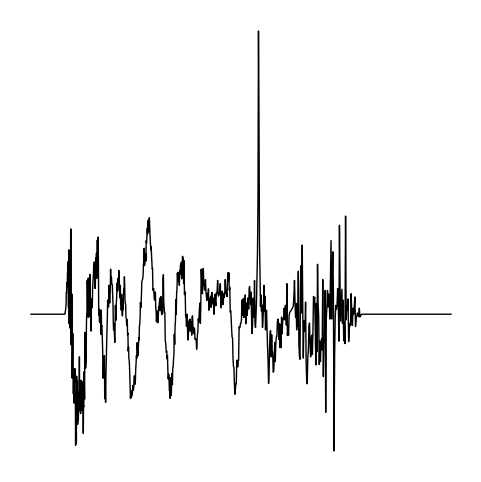

In [58]:
my_dpi = 100
fig, ax = plt.subplots(figsize=(6,6), dpi=my_dpi)
ax.plot(wavelength, main_wavelenght_t.iloc[:, 2500], lw=1.0, ls='-', color='k', alpha=1)
ax.axis('off')
ax.set_box_aspect(1)
#ax.set_xlim(2500, 10000)
#ax.set_ylim(0,1)
plt.show()